## Import Libraries

In [1]:
from fastai.vision import *
from fastai import *
from fastai.data_block import *

from pathlib import Path

from unet import dice_loss, dice_score, predict, plot_predictions

### Normalize Raw Images

Normalize the raw MRI scans and zero out the background (any pixels with negative value gets zero value). If you don't zero the background, the model will have difficulty predicting the brain mask. Note that this step needs to be done just once for both the training and validation raw images.

In [2]:
# import sys
# sys.path.extend(['../'])
# from Vent_Seg_Preprocessing.helper import normalize
# import numpy as np

In [3]:
# train_raw_images_path = Path("/data/public/Segmentation_Dataset/MR_Dataset_Atlas/train/raw_images")
# validation_raw_images_path = Path("/data/public/Segmentation_Dataset/MR_Dataset_Atlas/validation/raw_images")

In [4]:
# for fp in list(train_raw_images_path.iterdir()):
#     name = str(fp).split("/")[-1]
#     f = np.load(fp)
#     normalized_f = normalize(f)
#     normalized_f[normalized_f < 0] = 0
#     np.save("/data/public/Segmentation_Dataset/MR_Dataset_Atlas/train/normalized_raw_images/{name}".format(name=name), normalized_f)
    

In [5]:
# for fp in list(validation_raw_images_path.iterdir()):
#     name = str(fp).split("/")[-1]
#     f = np.load(fp)
#     normalized_f = normalize(f)
#     normalized_f[normalized_f < 0] = 0
#     np.save("/data/public/Segmentation_Dataset/MR_Dataset_Atlas/validation/normalized_raw_images/{name}".format(name=name), normalized_f)

### Set Pytorch to use a specific GPU

In [6]:
torch.cuda.set_device(2)

### Data Preparation

In [7]:
data_path = Path("/data/public/Segmentation_Dataset/MR_Dataset_Atlas")
trn_img = sorted(list(Path(data_path/"train/normalized_raw_images").iterdir()))
trn_mask = sorted(list(Path(data_path/"train/brain_atlas").iterdir()))
valid_img = sorted(list(Path(data_path/"validation/normalized_raw_images").iterdir()))
valid_mask = sorted(list(Path(data_path/"validation/brain_masks").iterdir()))

In [8]:
set_of_trn_images = set([str(fp).split("/")[-1] for fp in trn_img])
set_of_trn_masks = set([str(fp).split("/")[-1] for fp in trn_mask])
set_of_valid_images = set([str(fp).split("/")[-1] for fp in valid_img])
set_of_valid_masks = set([str(fp).split("/")[-1] for fp in valid_mask])

### It appears that some train brain atlas masks could not be created during image preprocessing

In [5]:
print(len(set_of_trn_masks - set_of_trn_images))
print(len(set_of_trn_images- set_of_trn_masks))
print(len(set_of_valid_masks - set_of_valid_images))
print(len(set_of_valid_images- set_of_valid_masks))

0
12
0
0


In [6]:
trn_img = list(filter(lambda x: str(x).split("/")[-1] in set_of_trn_masks, trn_img))

In [7]:
print(f"Size of Train Dataset Images: {len(trn_img)} Images")
print(f"Size of Validation Dataset Images: {len(valid_img)} Images")
print(f"Size of Train Dataset Masks: {len(trn_mask)} Images")
print(f"Size of Validation Dataset Masks: {len(valid_mask)} Images")

Size of Train Dataset Images: 2143 Images
Size of Validation Dataset Images: 15 Images
Size of Train Dataset Masks: 2143 Images
Size of Validation Dataset Masks: 15 Images


In [8]:
for i in range(len(trn_img)):
    assert str(trn_img[i]).split("/")[-1] == str(trn_mask[i]).split("/")[-1]

for i in range(len(valid_img)):
    assert str(valid_img[i]).split("/")[-1] == str(valid_mask[i]).split("/")[-1]

In [10]:
class MRI_3D_Dataset(object):
    def __init__(self, images, ventricles, transform=None):
        self.images = images
        self.ventricles = ventricles
        self.transform = transform
    
    def __getitem__(self, index):
        image_voxel = np.load(self.images[index]).astype(np.float32)
        mask_voxel = np.load(self.ventricles[index]).astype(np.float32)
        if self.transform:
            image_voxel, mask_voxel = self.transform(image_voxel, mask_voxel)
        return FT(image_voxel[None,:]), FT(mask_voxel) 

    def __len__(self):
        return len(self.images)
    
train_ds = MRI_3D_Dataset(trn_img, trn_mask)
valid_ds = MRI_3D_Dataset(valid_img, valid_mask)   

data = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, bs=3)

### Create 3D Unet

In [11]:
unet = VolumetricUnet(in_channel=1, out_channel=4, num_classes=1)

In [12]:
learner = Learner(data=data, model=unet)

In [13]:
learner.loss_func = dice_loss
learner.metrics = [dice_score]

### We use 16 bit Fixed Precision to allow us to go from 1 image to 3 images in batch size

In [14]:
learner.to_fp16();

## Find optimal Learning rate

With the below learning rate plot we chose 3e-2 since the loss is smoothly decreasing at that value

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


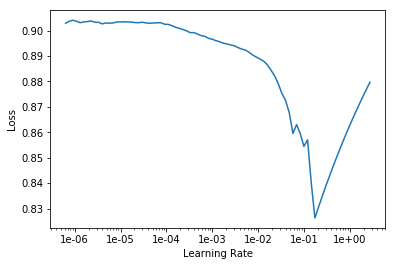

In [17]:
# learner.lr_find()
# learner.recorder.plot()

## Fit model with learning rate 3e-2 and 1 epochs

In [18]:
#learner.fit_one_cycle(1, 3e-2)

epoch,train_loss,valid_loss,dice_score
1,0.052732,0.048520,0.952086


## Save Model weights into current directory

In [19]:
#learner.save('DL_Brain_MR_ATLAS_1_epochs_3e-2_lr')

## Load Model

In [23]:
learner.load('DL_Brain_MR_ATLAS_1_epochs_3e-2_lr');

## Evaluate Predictions

In [24]:
images, preds, masks = predict(learner, data)

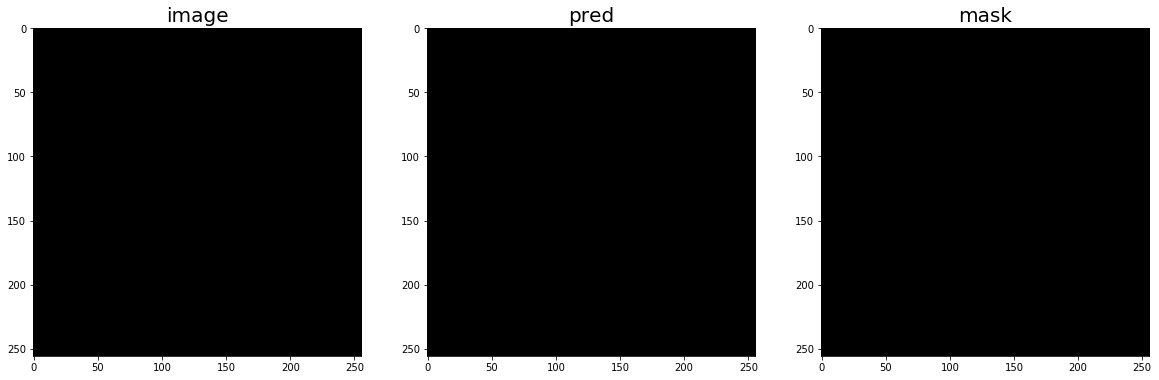

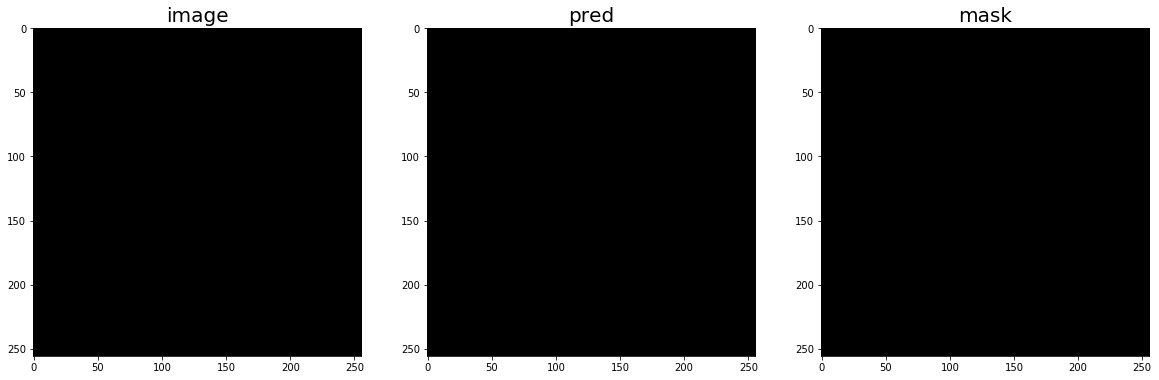

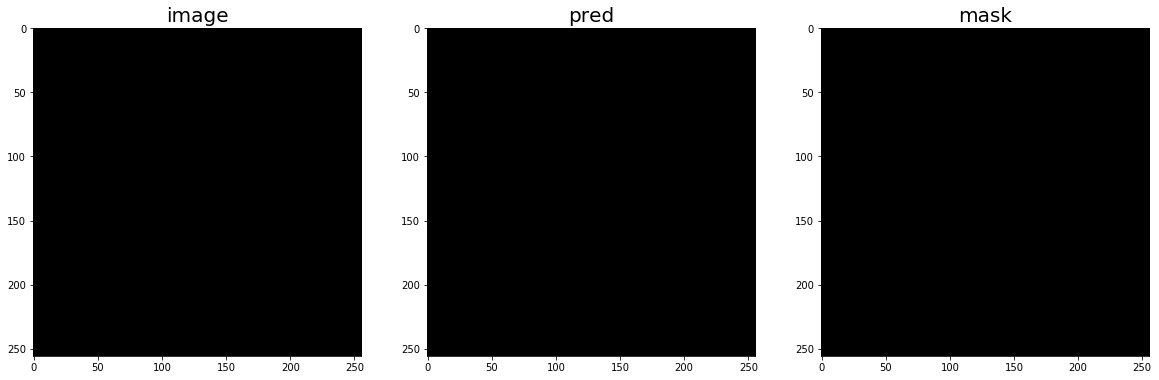

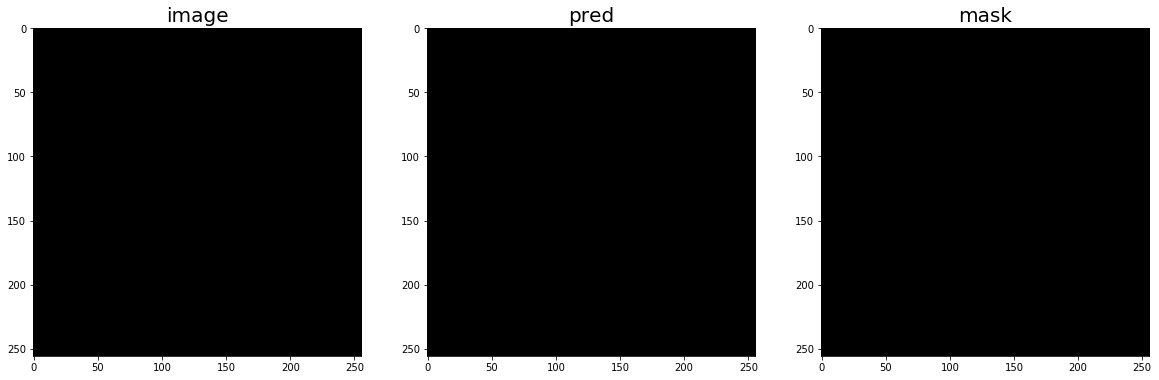

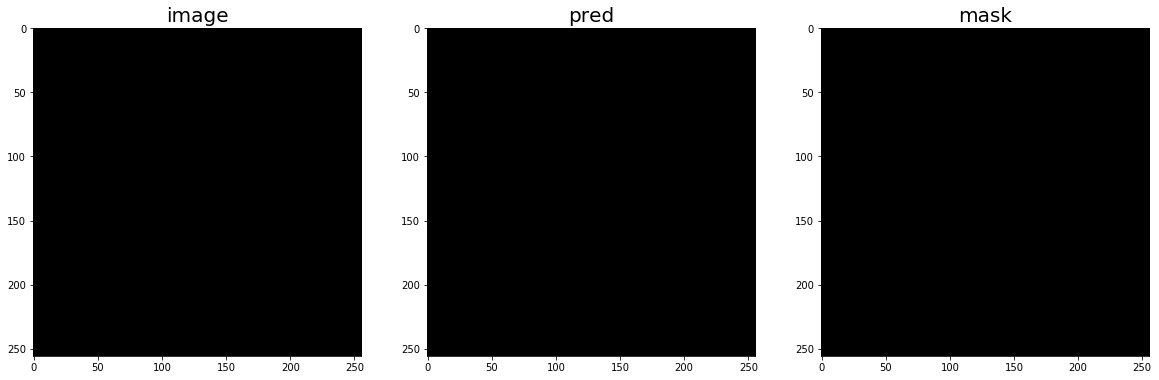

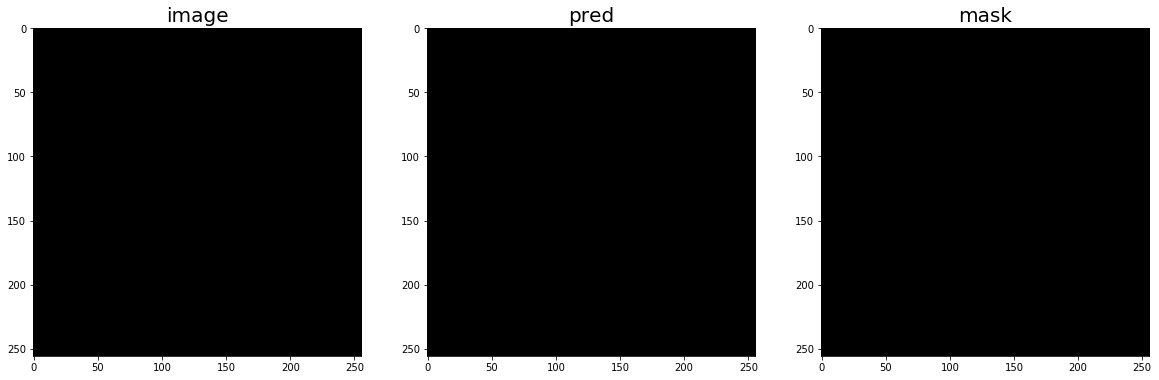

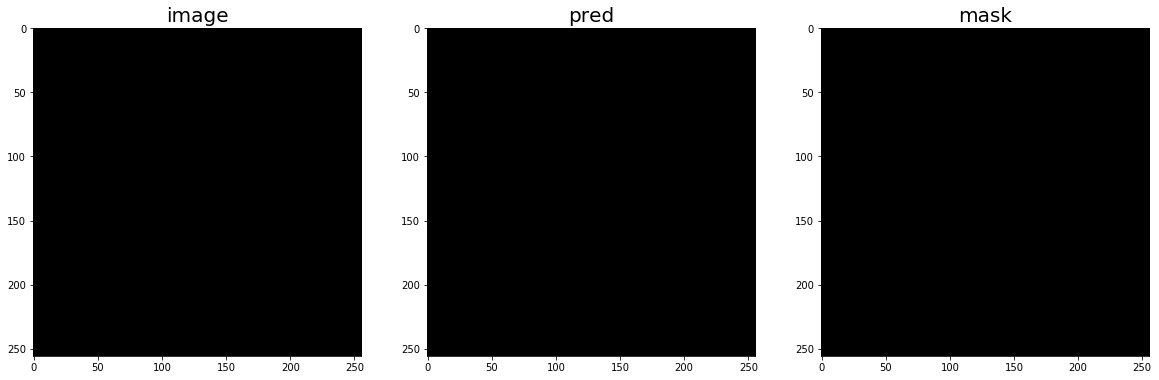

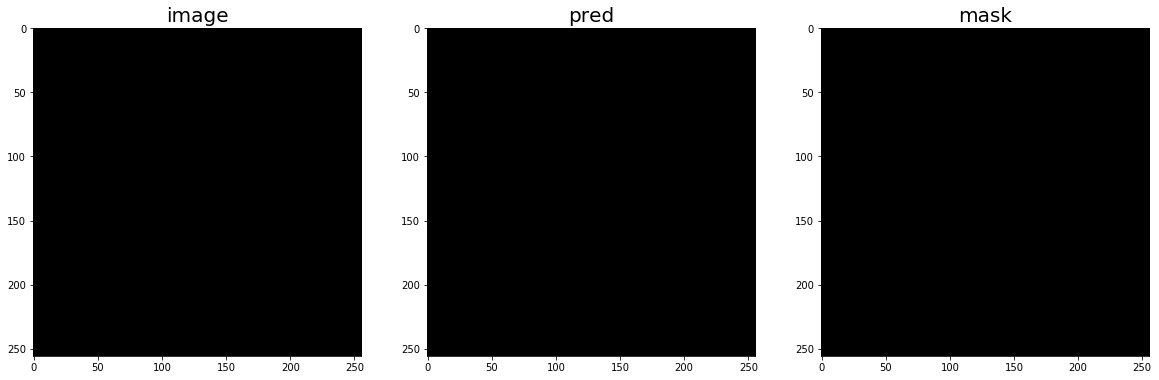

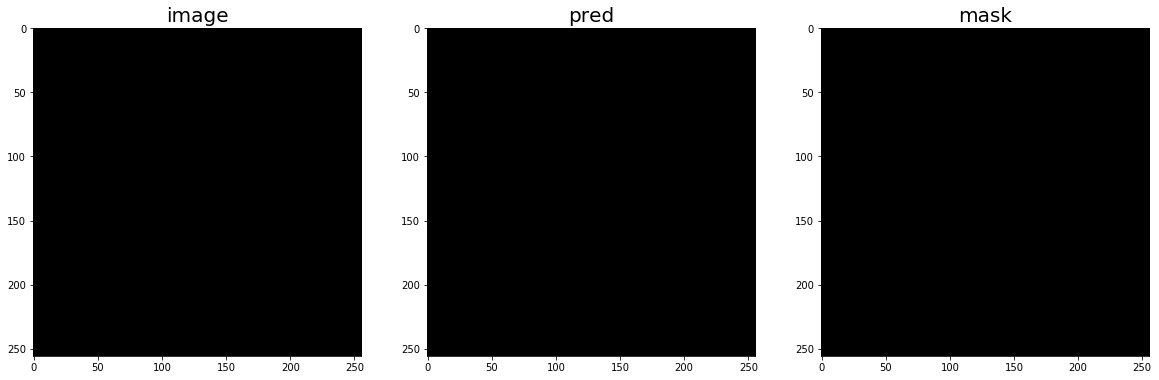

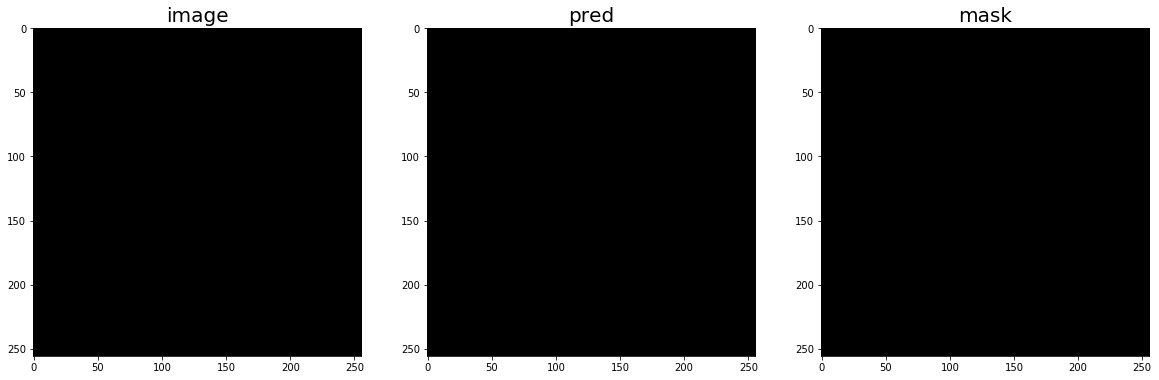

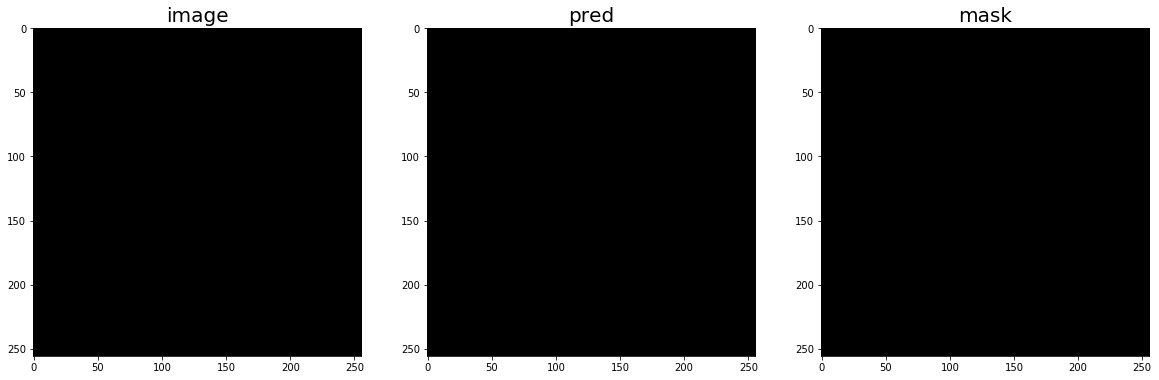

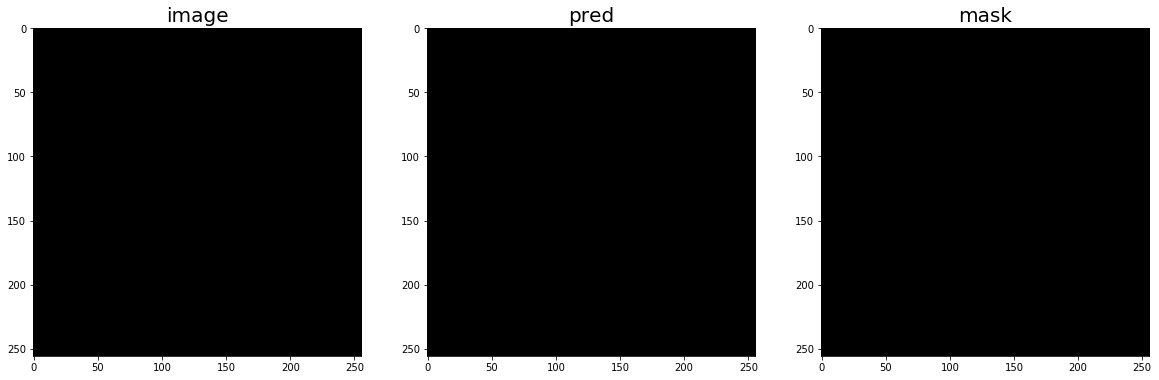

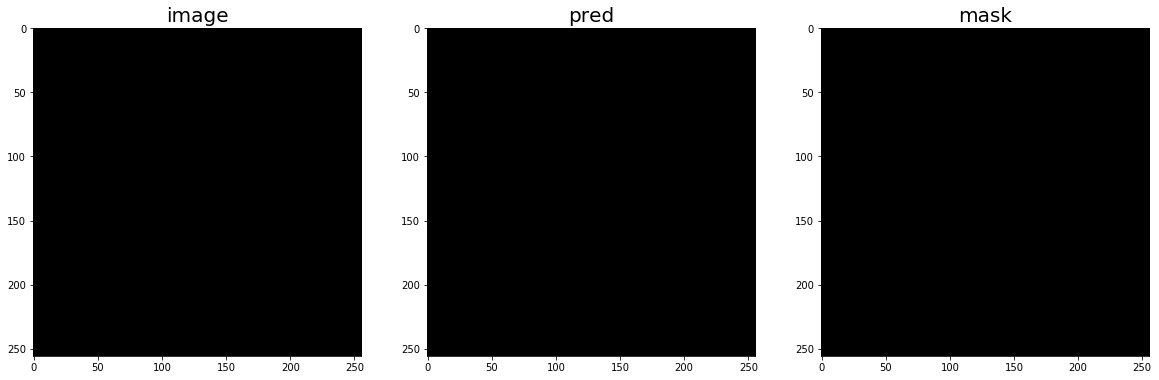

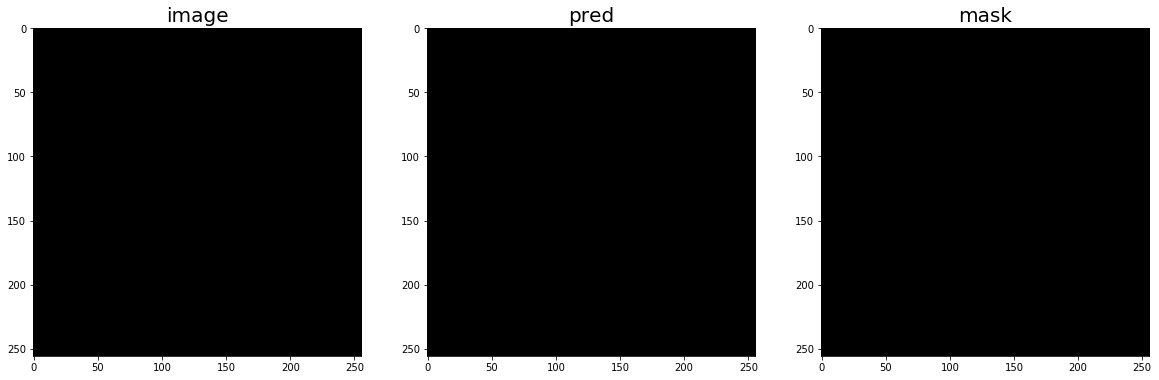

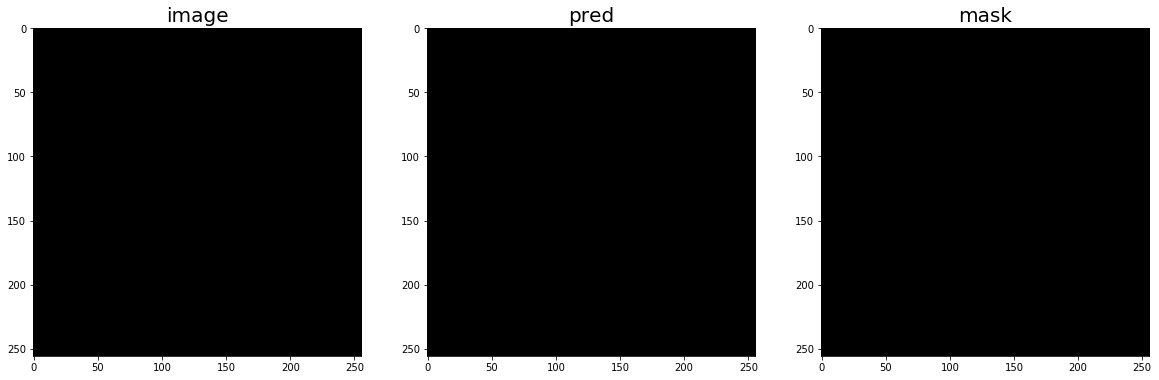

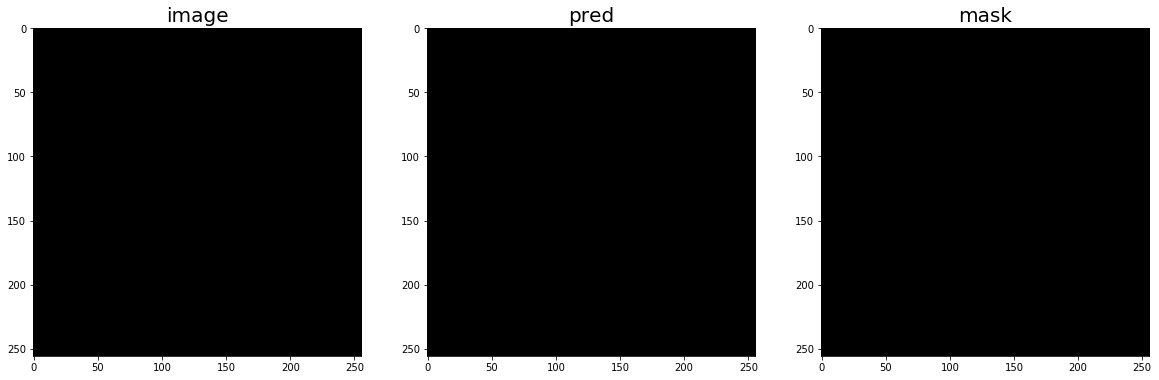

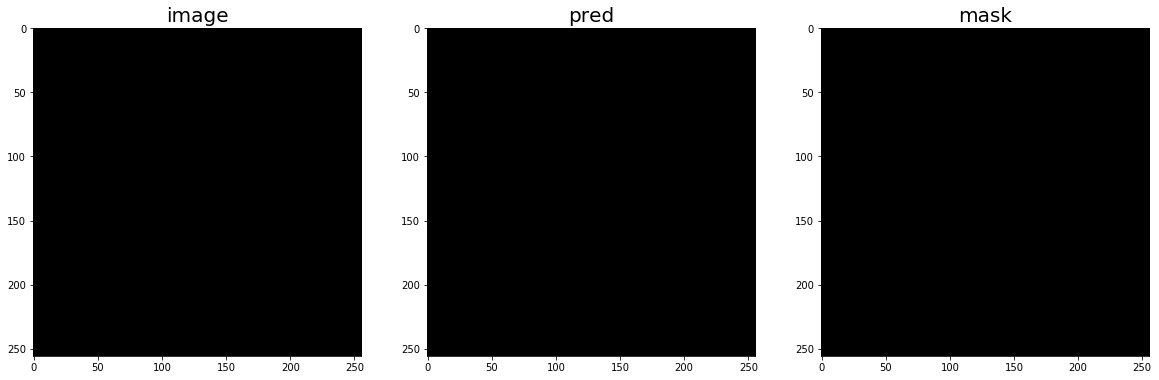

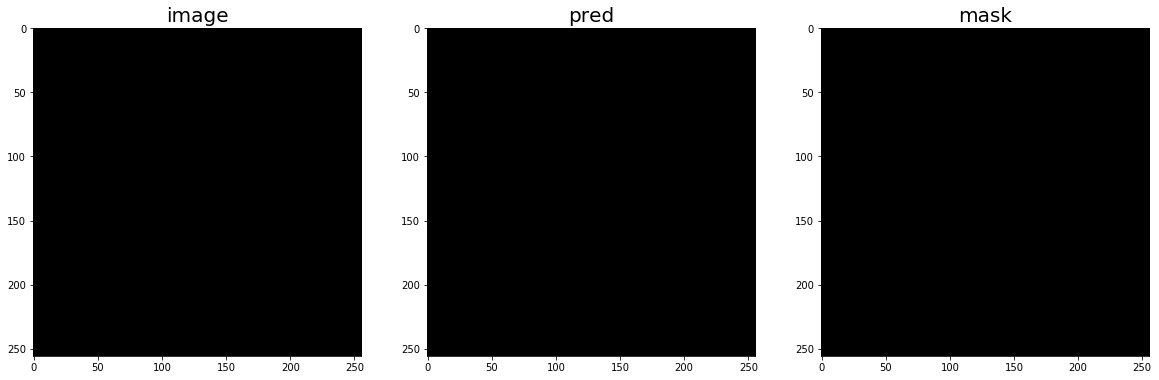

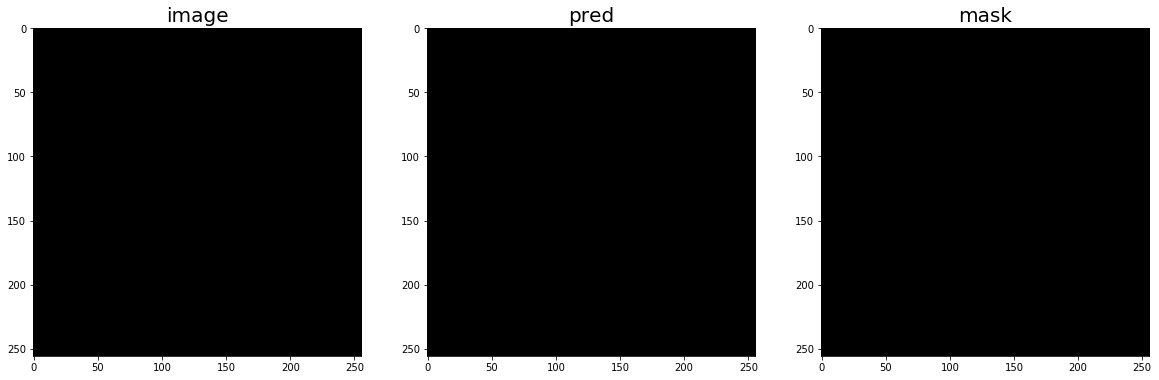

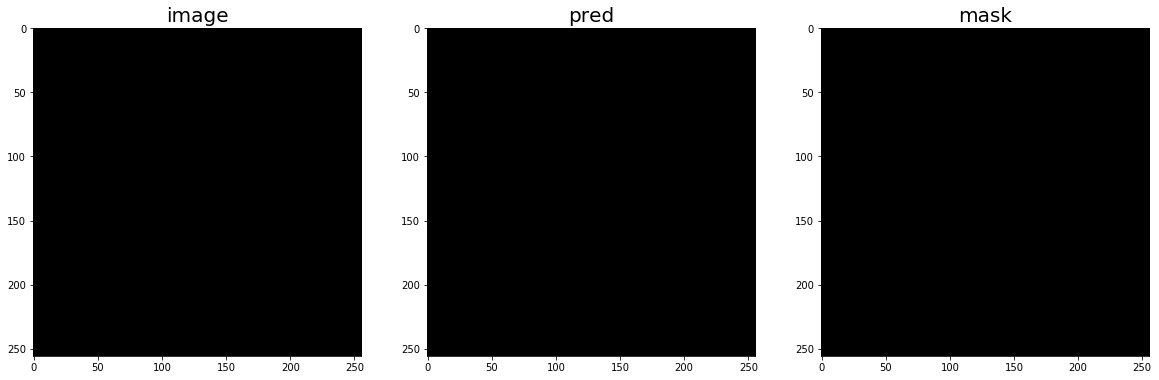

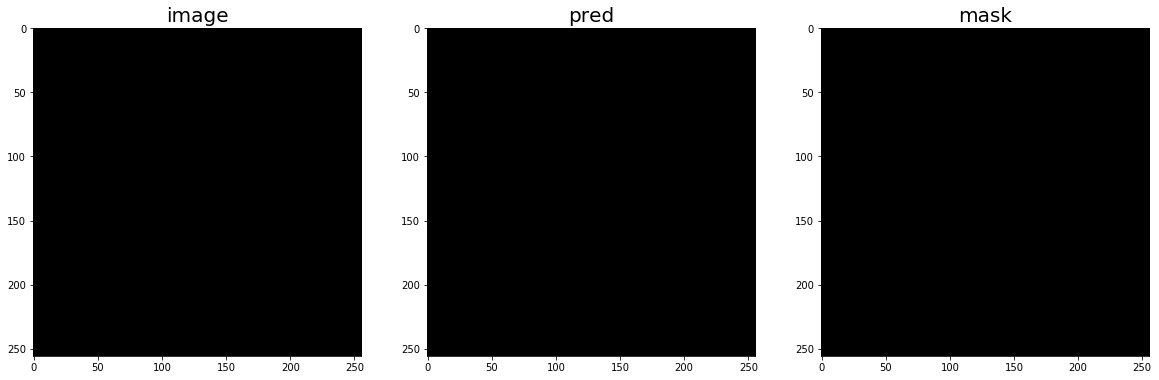

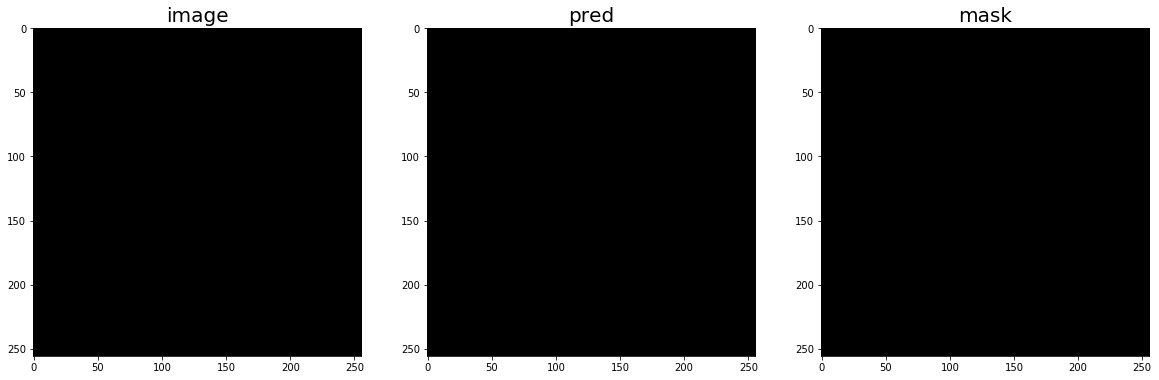

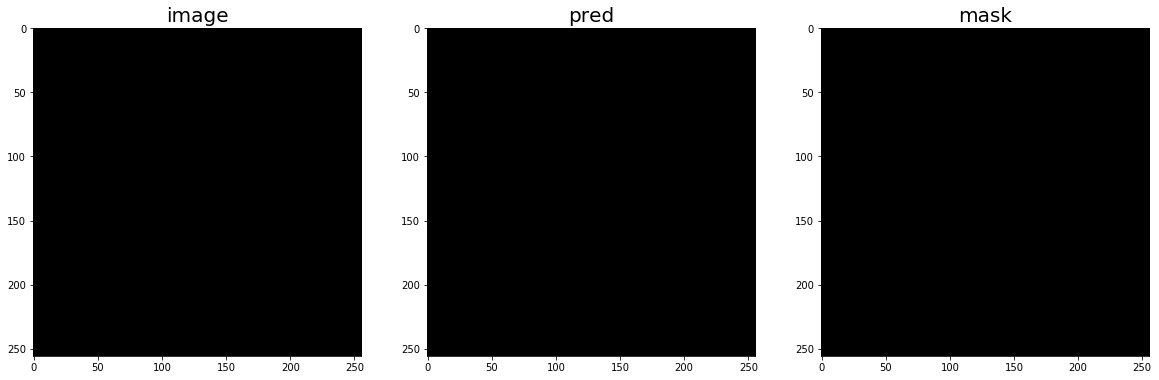

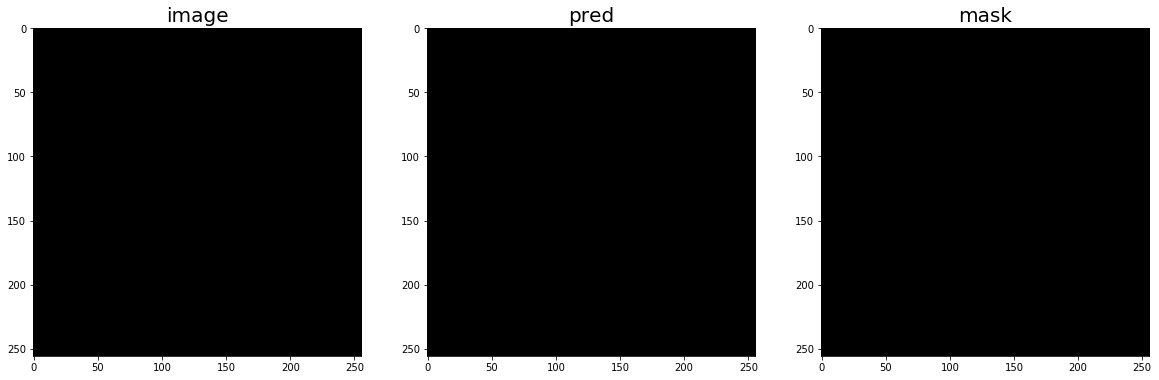

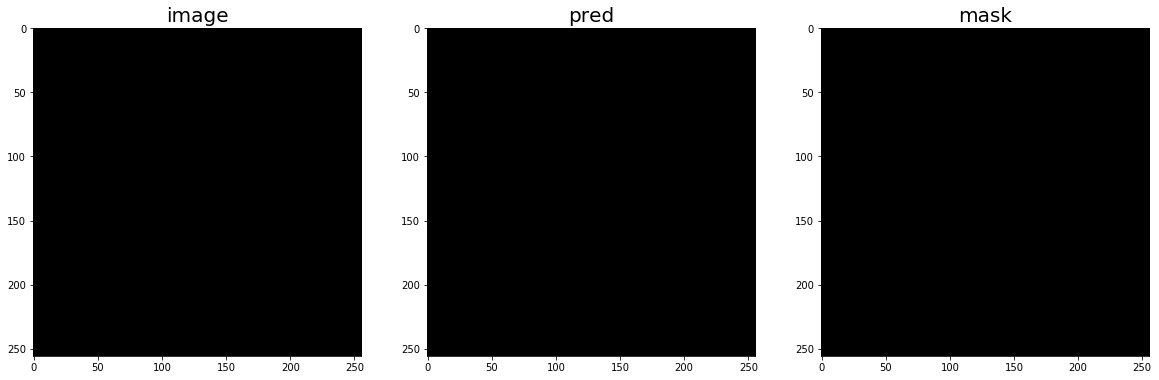

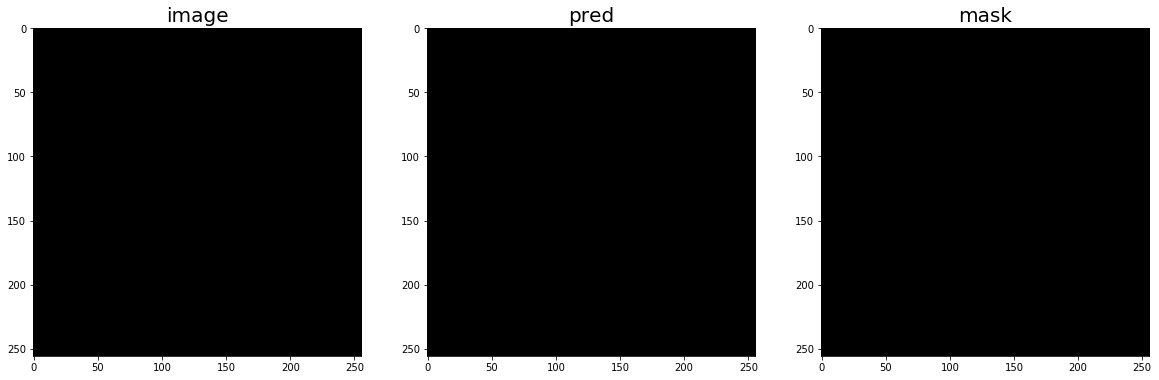

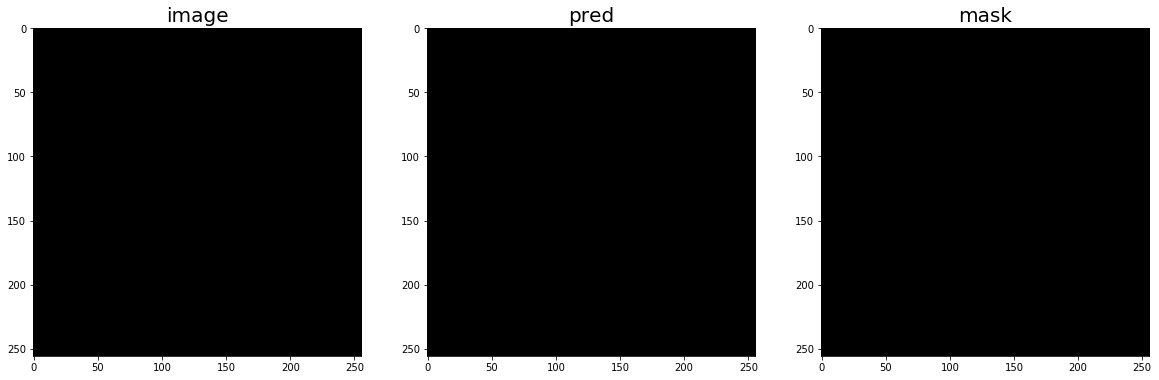

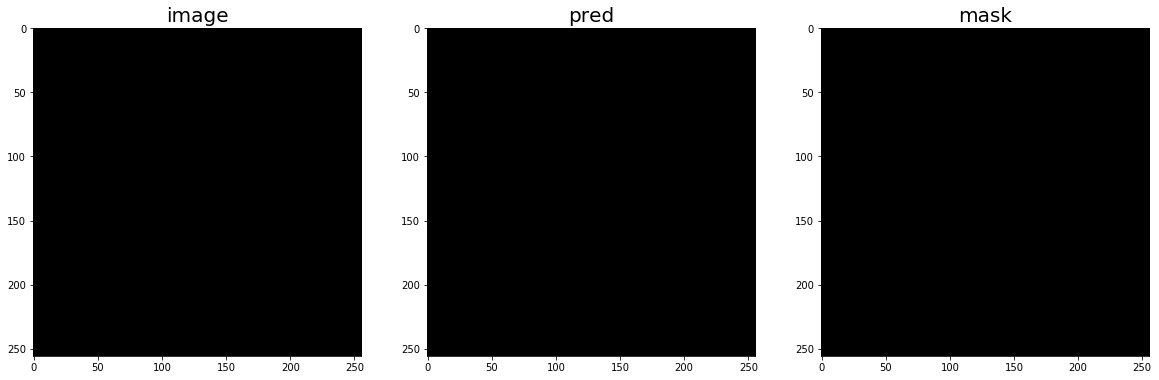

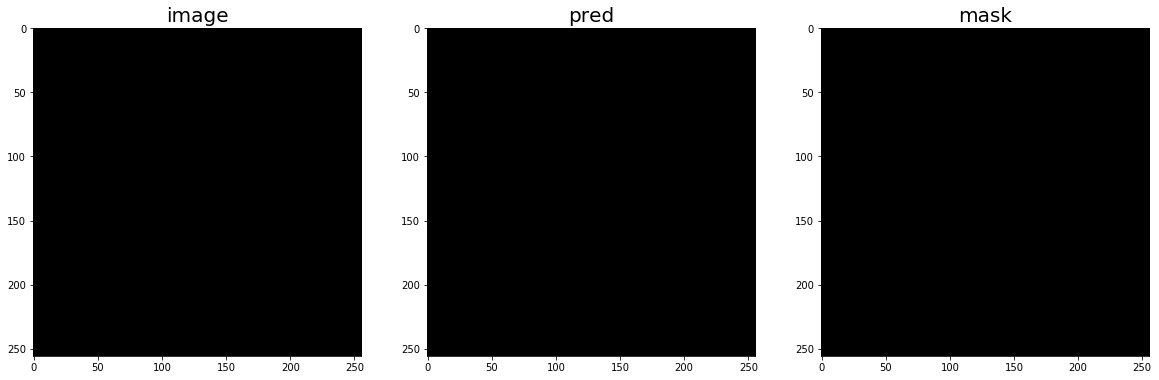

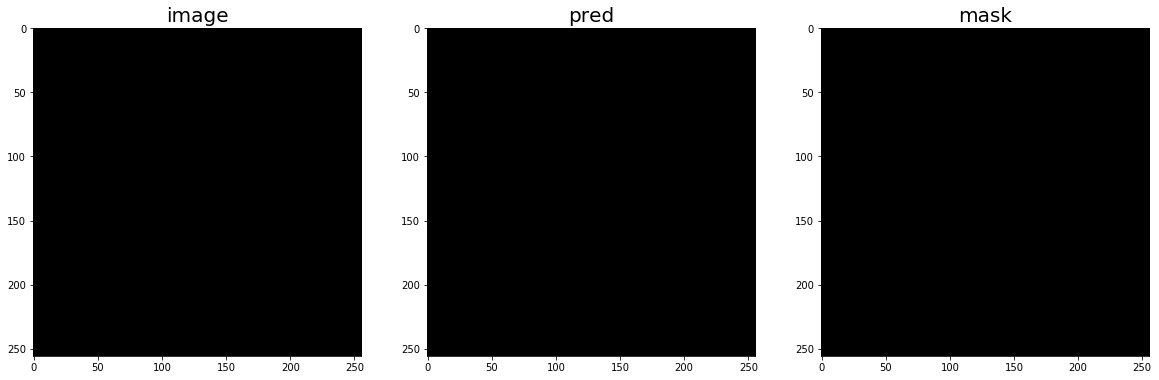

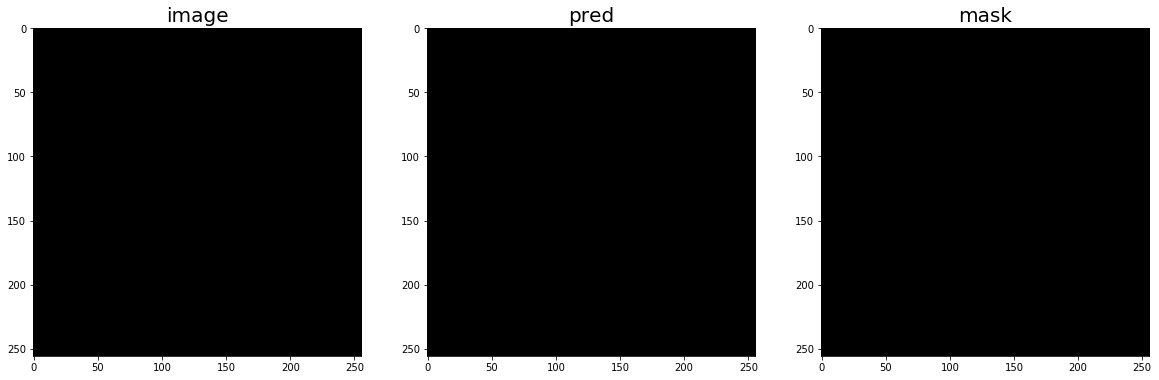

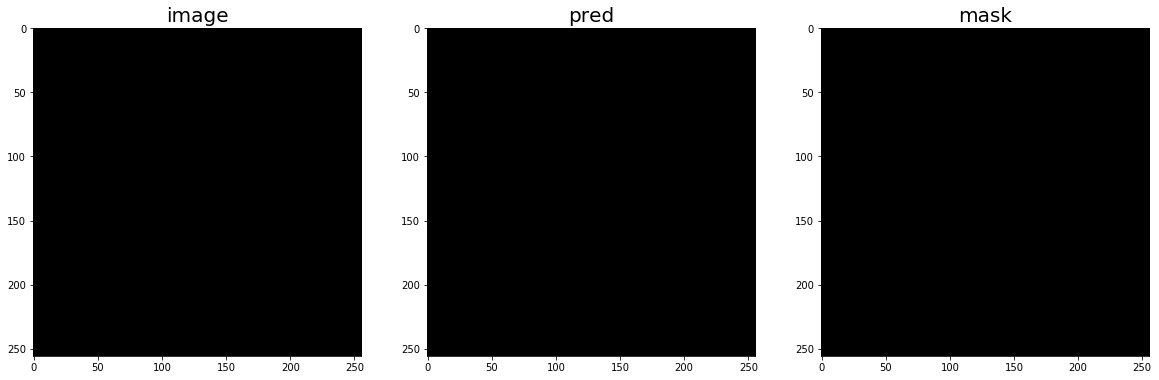

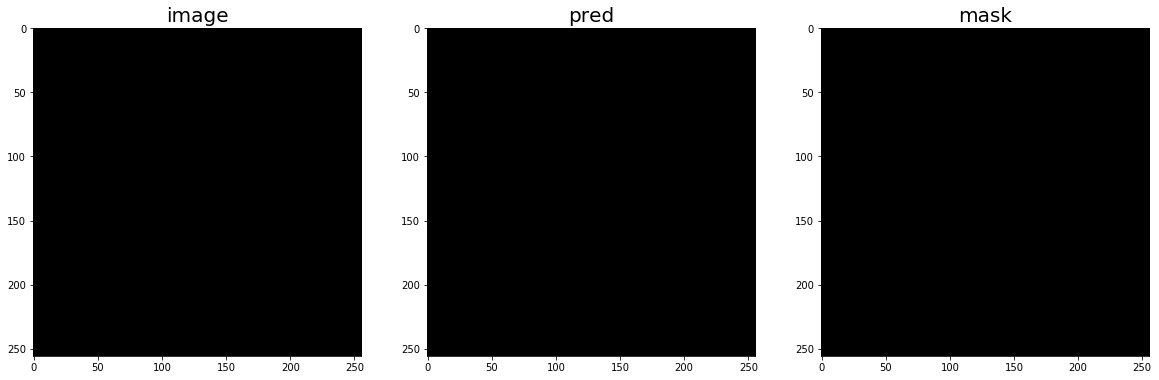

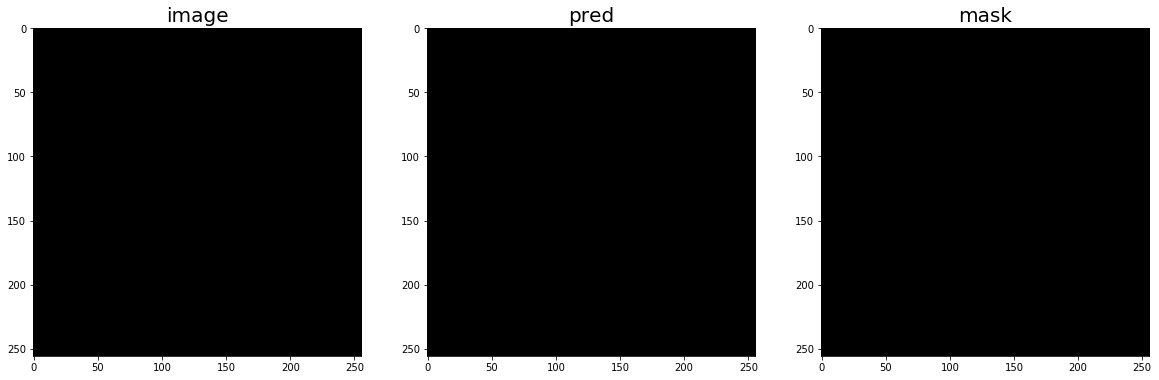

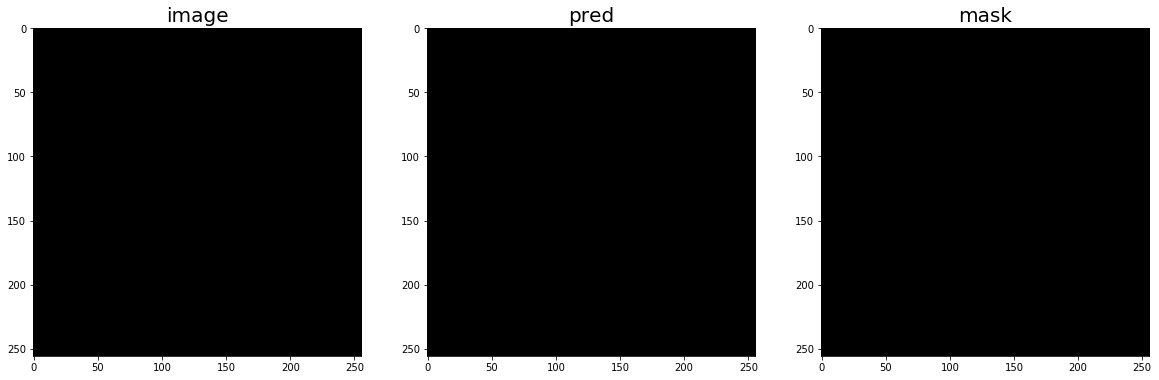

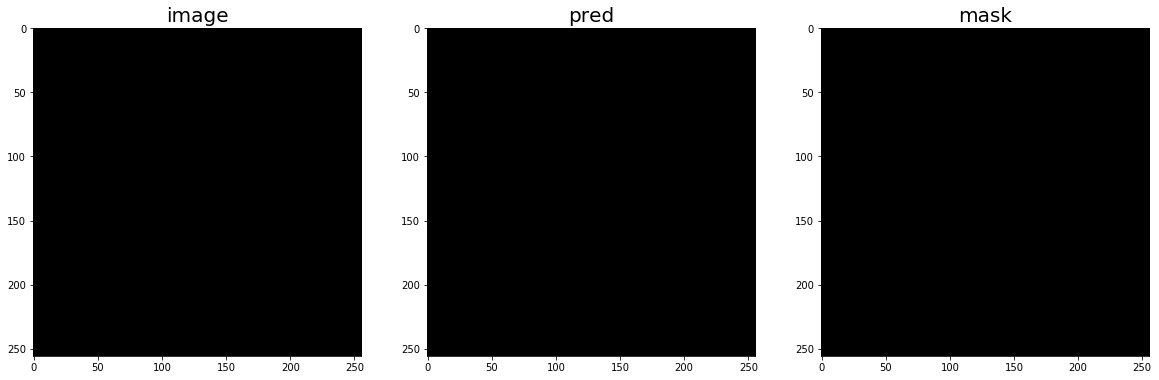

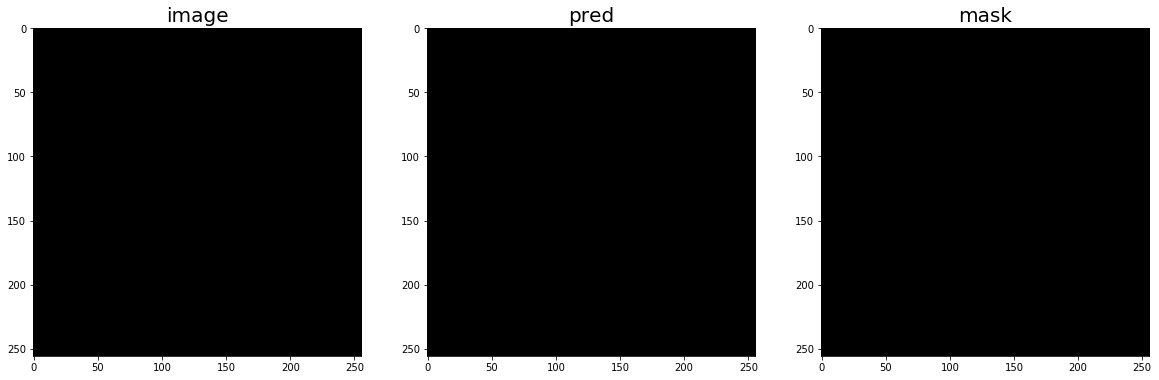

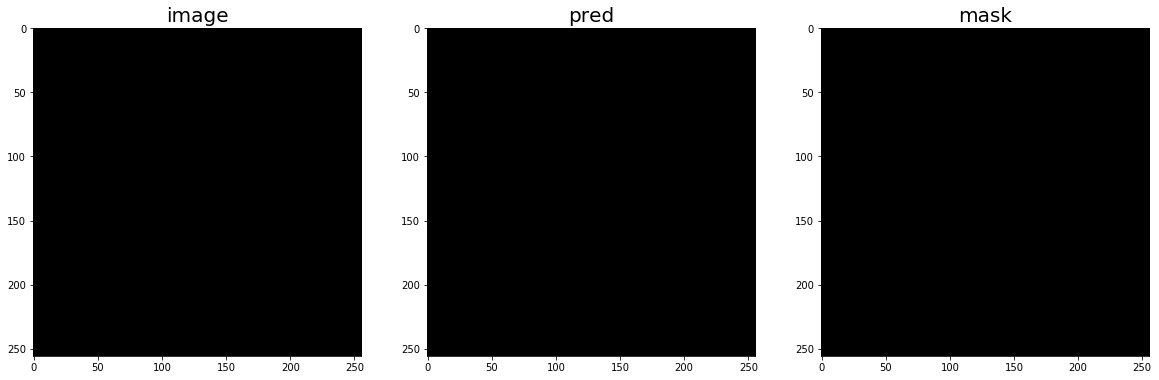

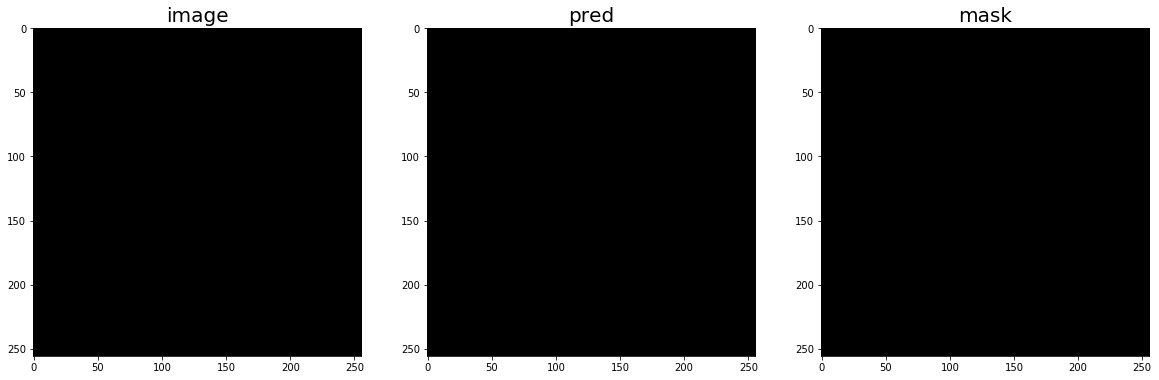

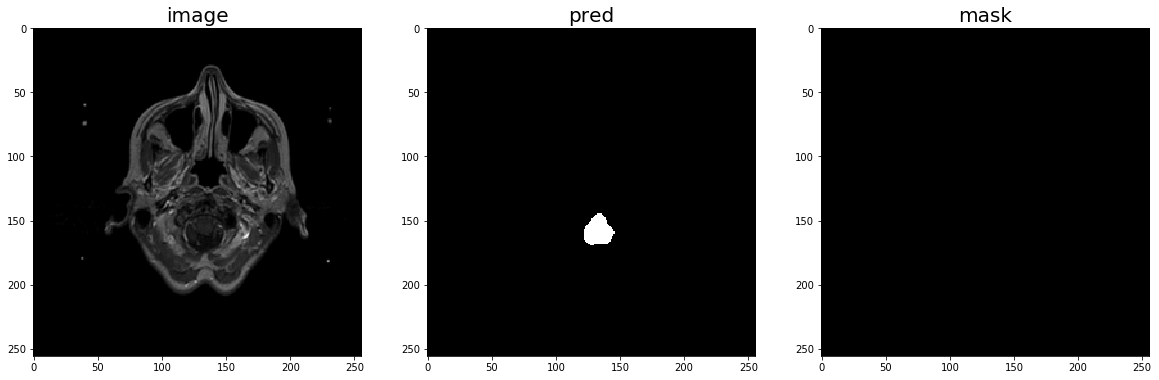

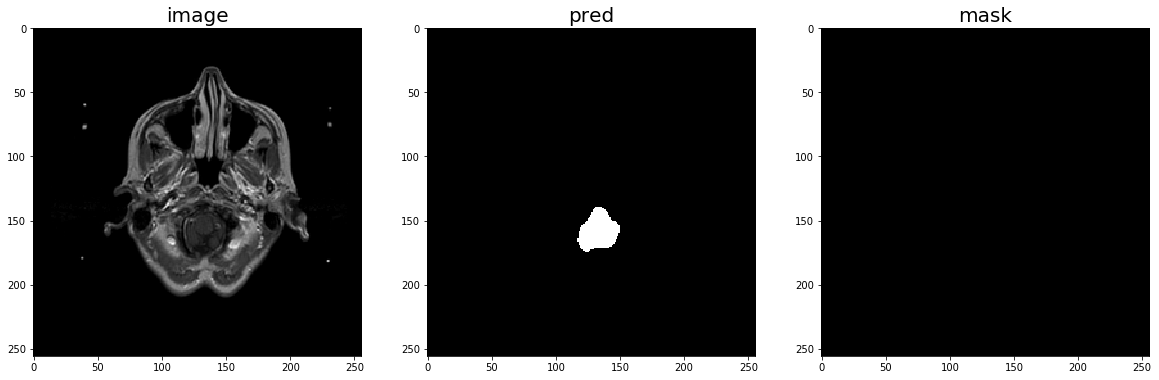

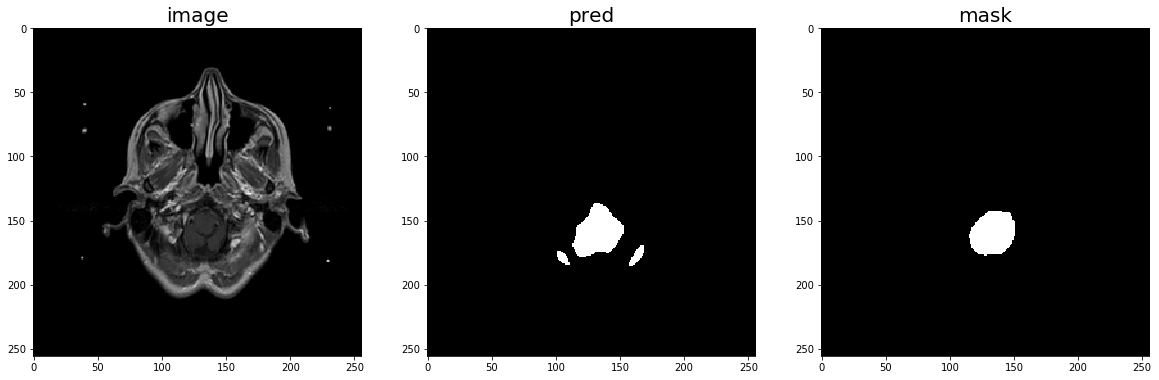

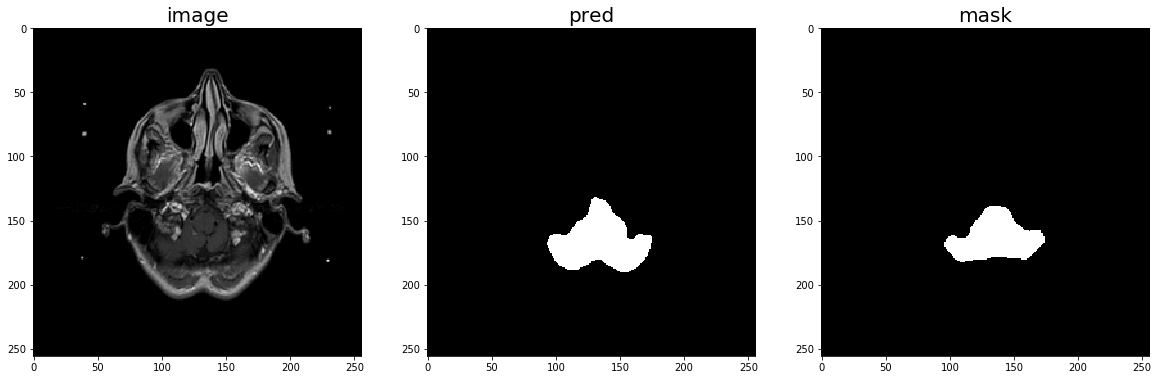

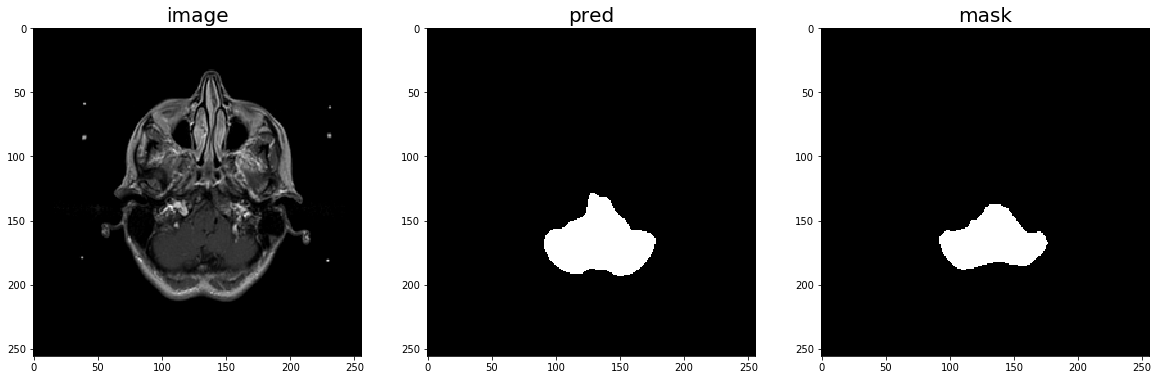

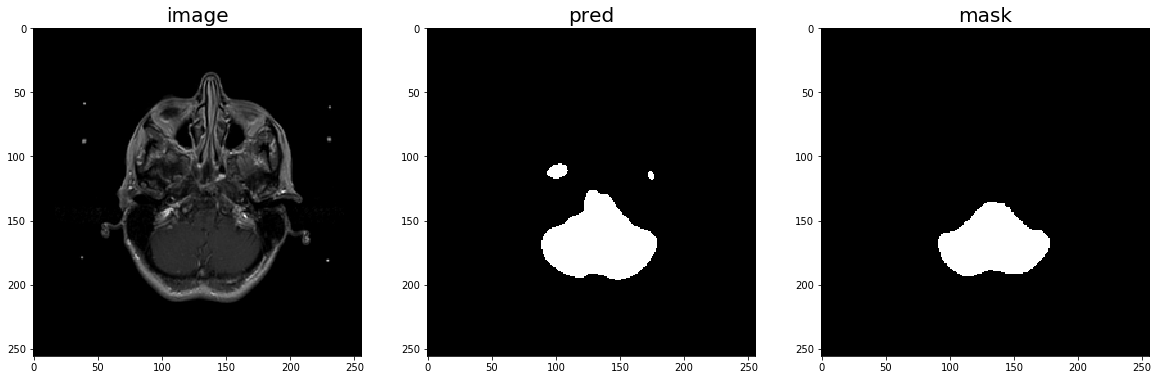

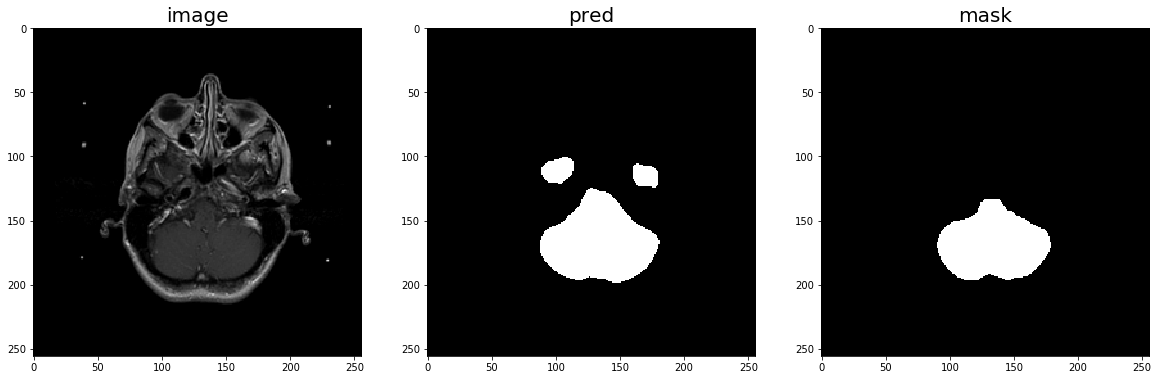

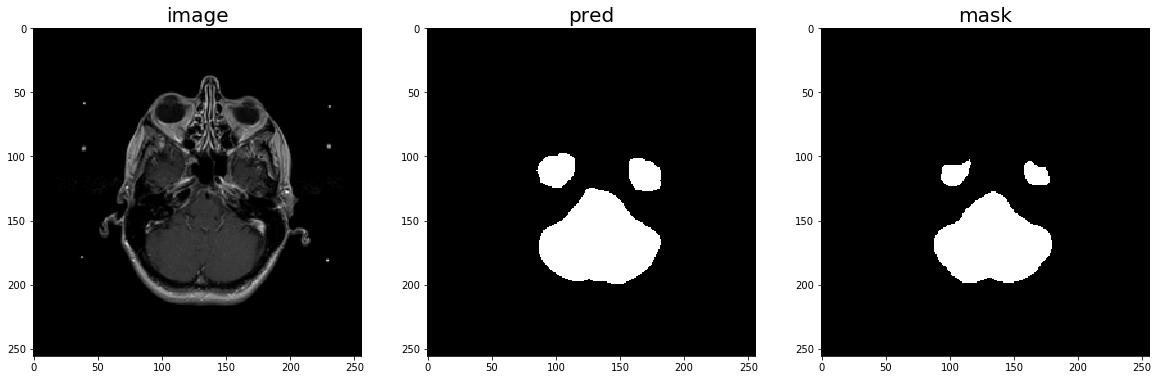

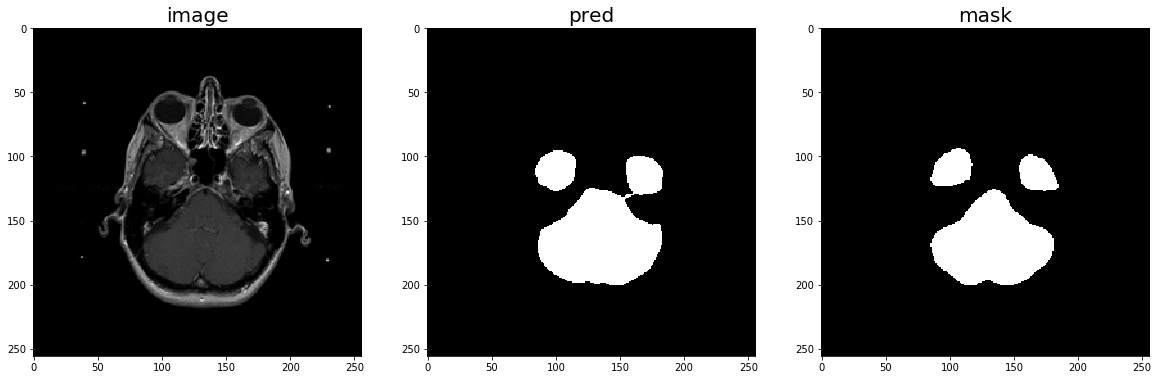

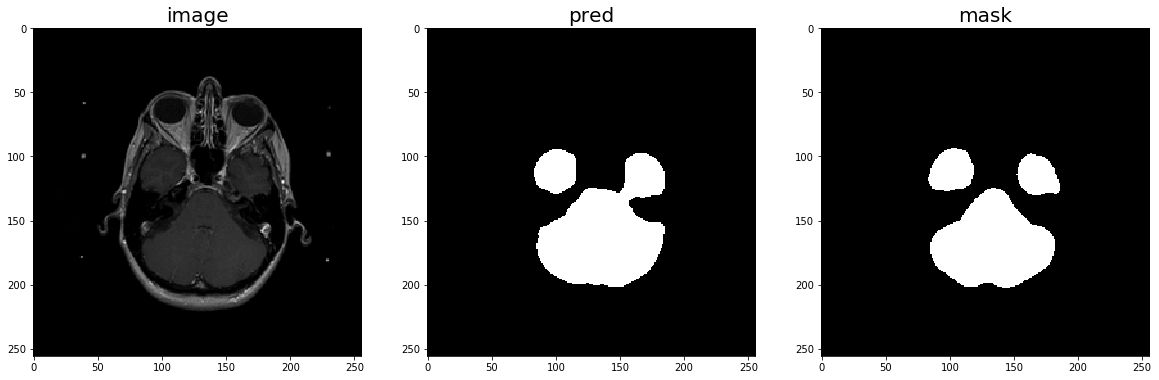

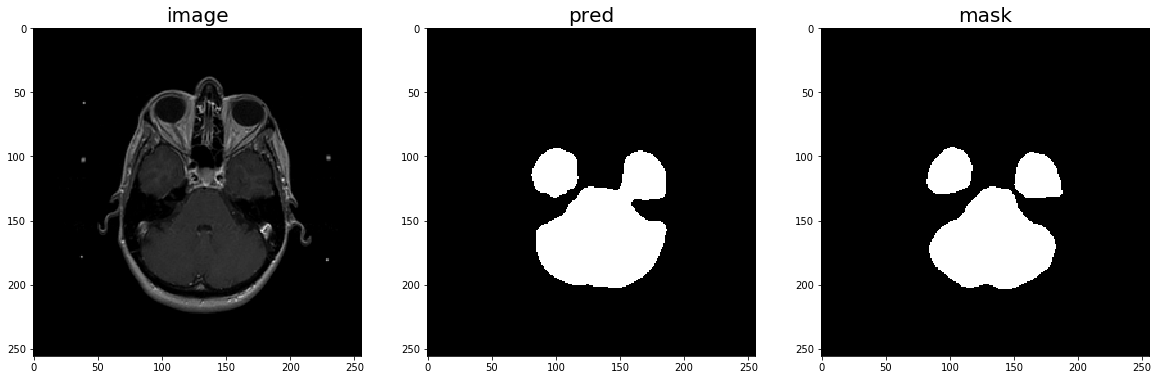

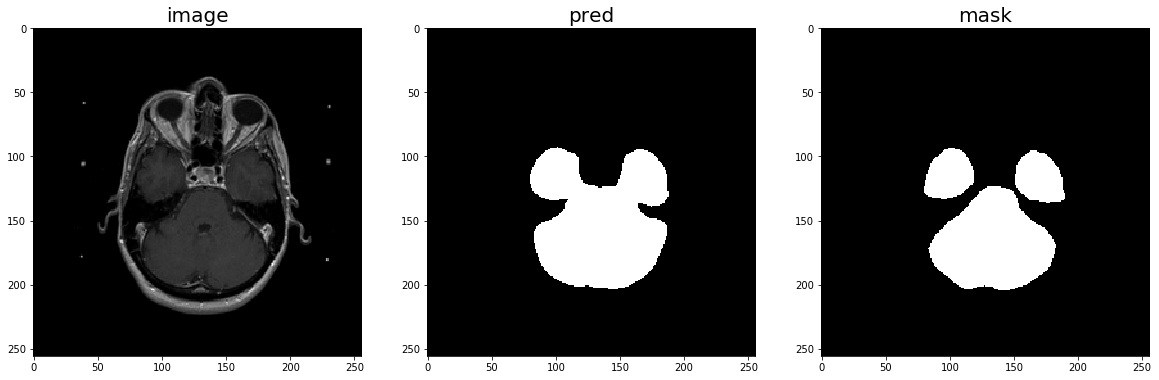

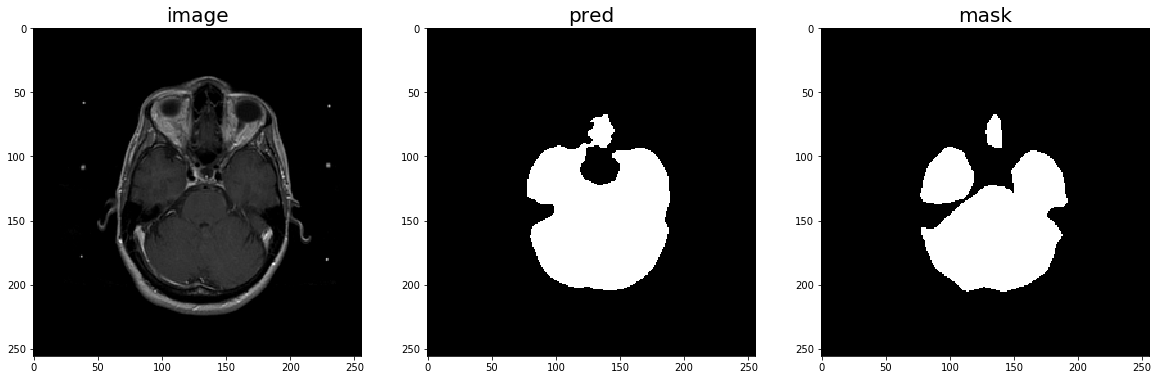

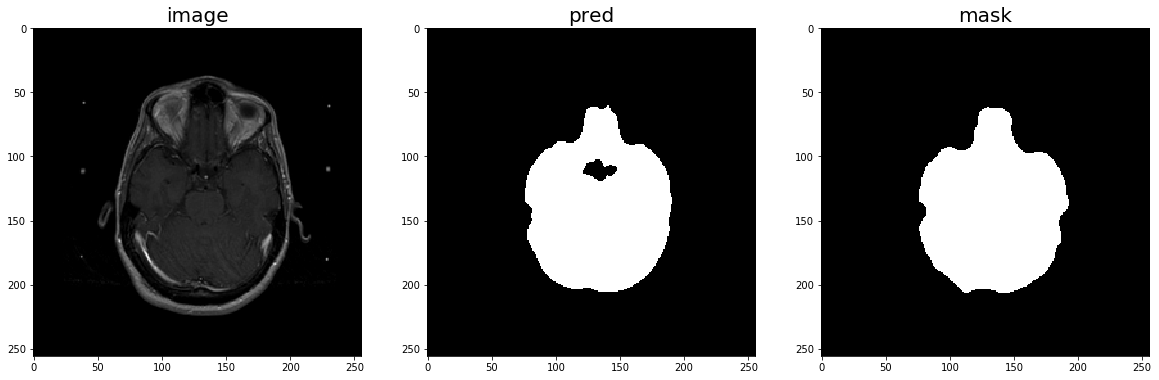

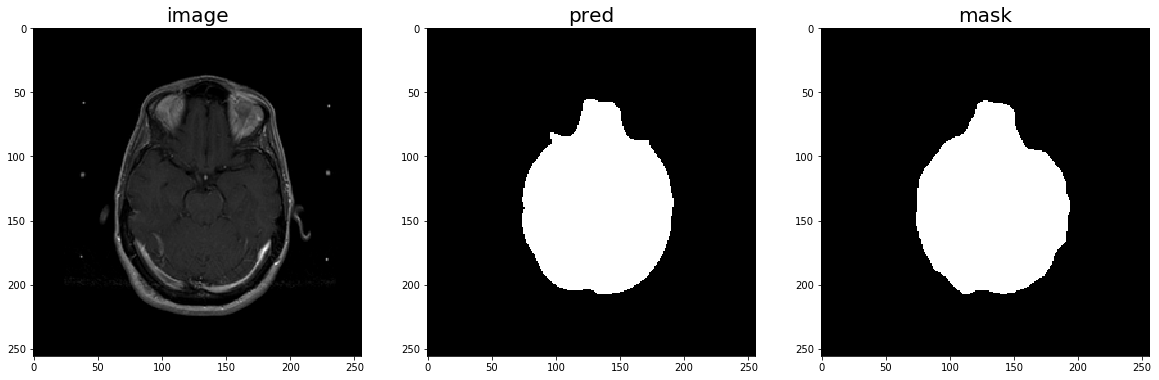

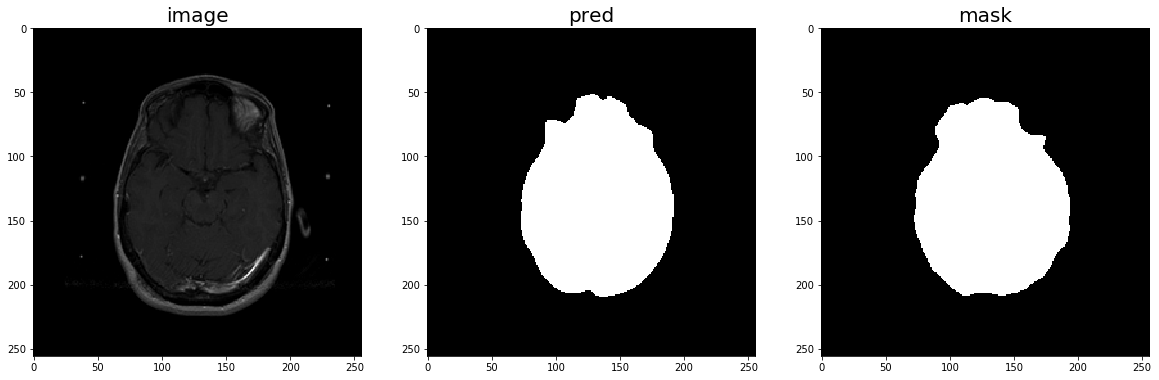

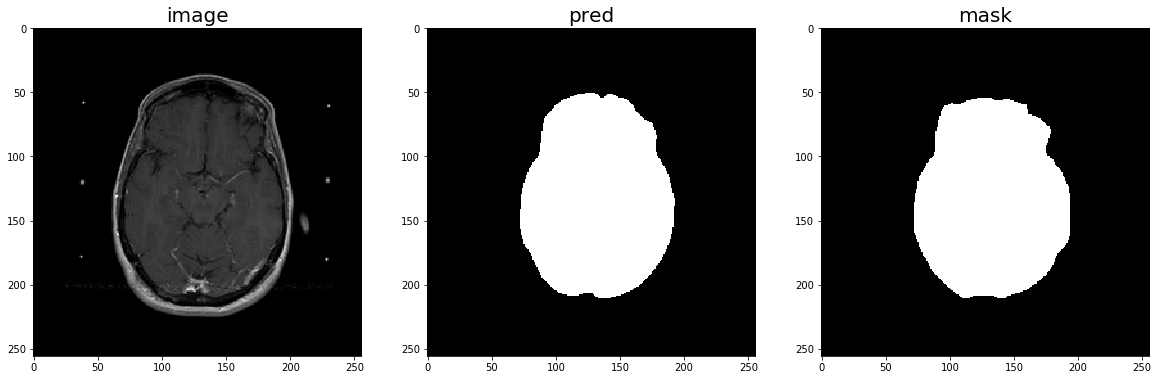

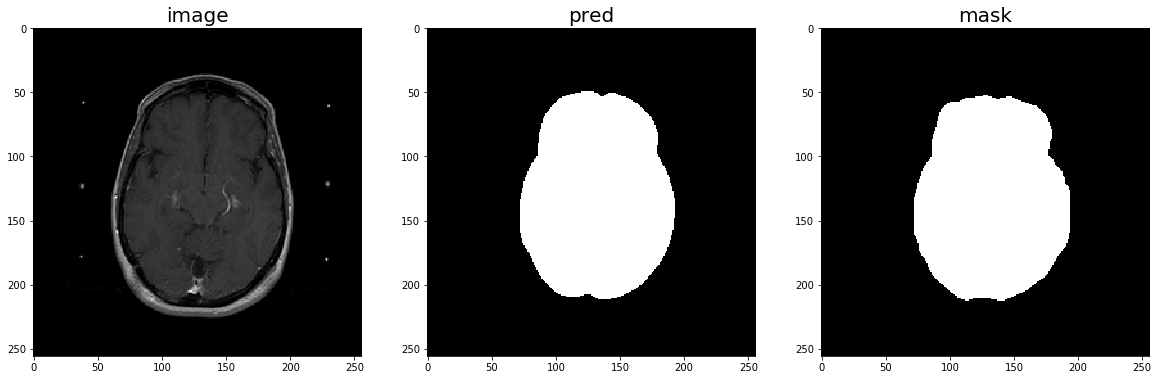

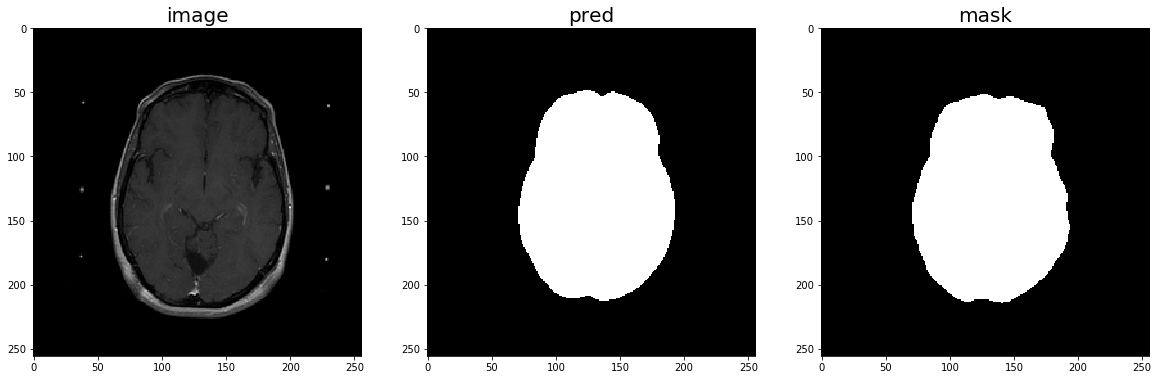

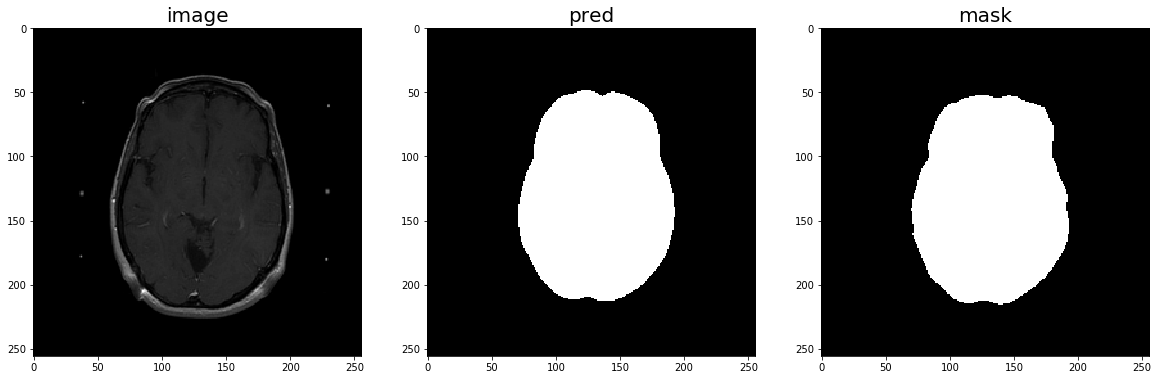

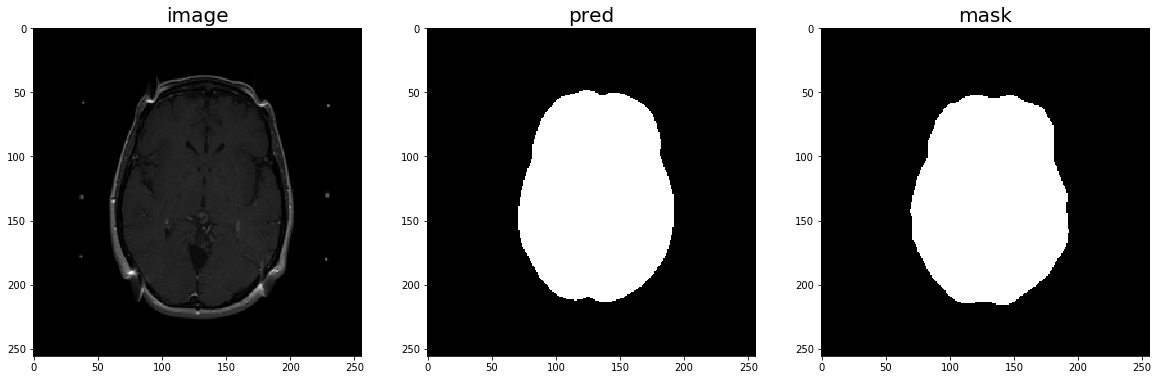

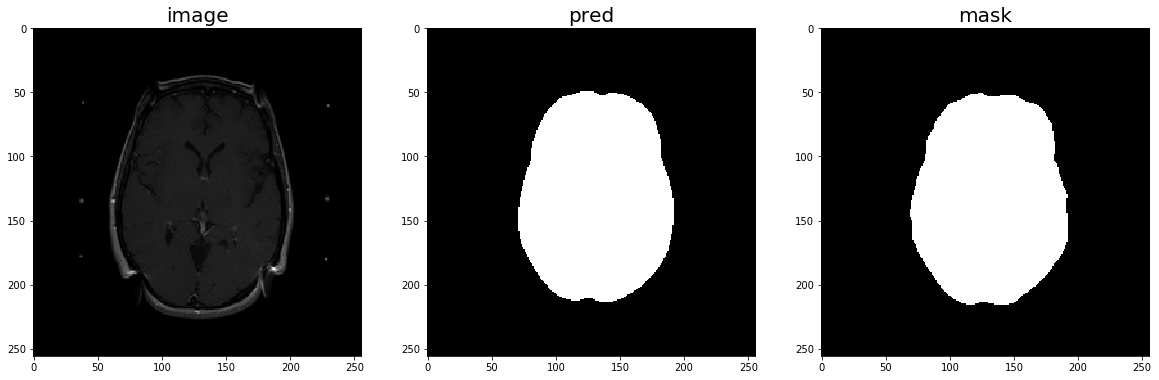

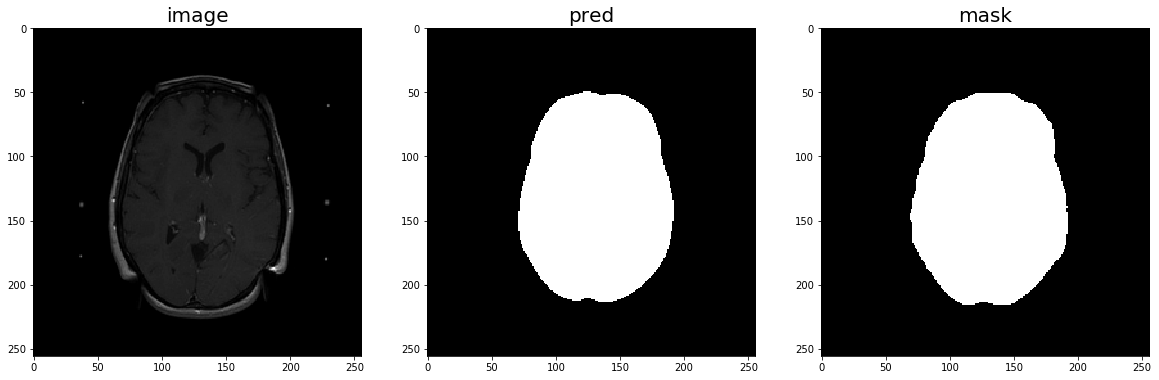

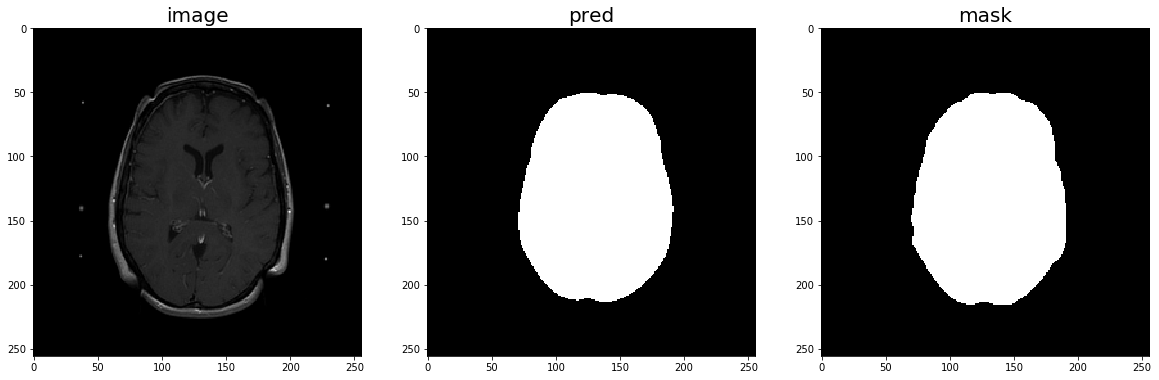

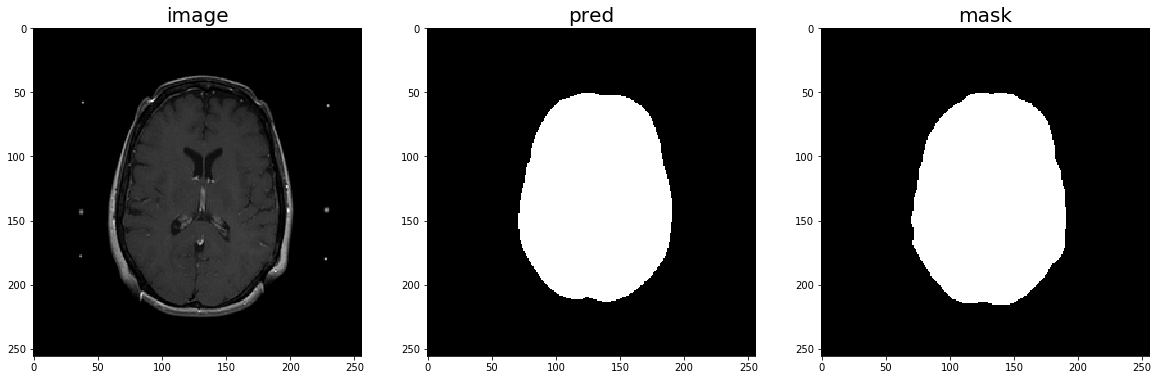

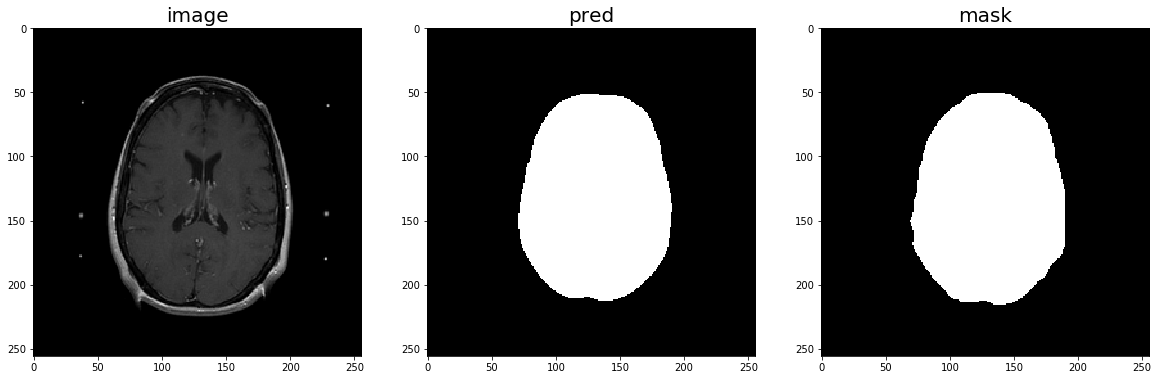

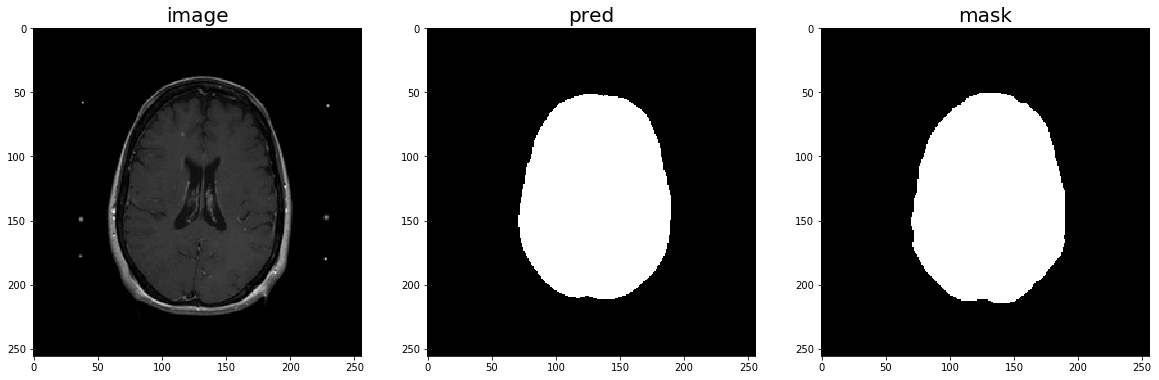

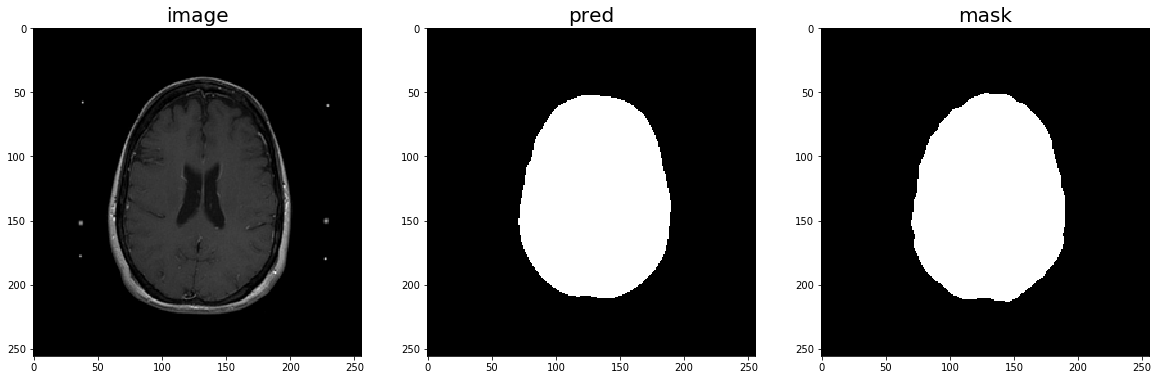

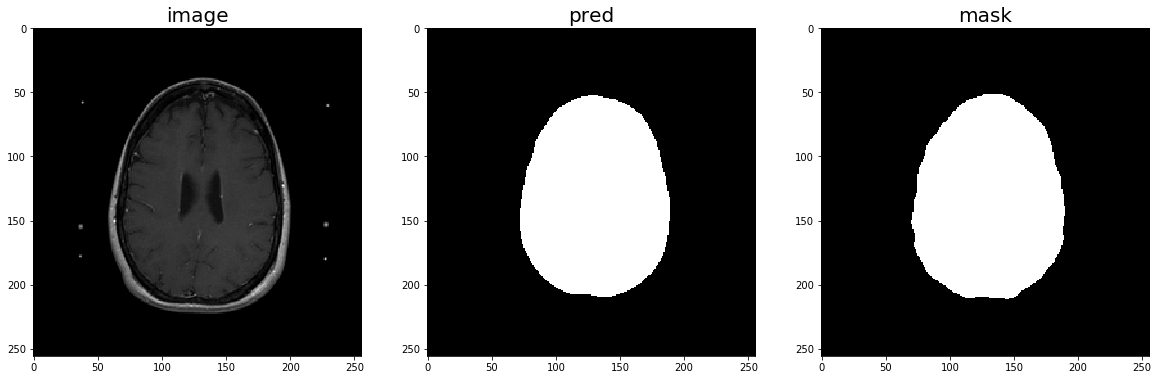

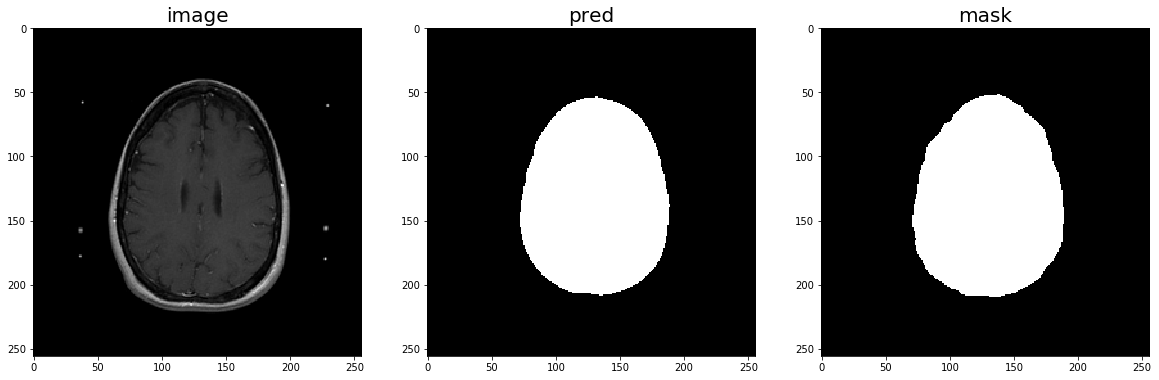

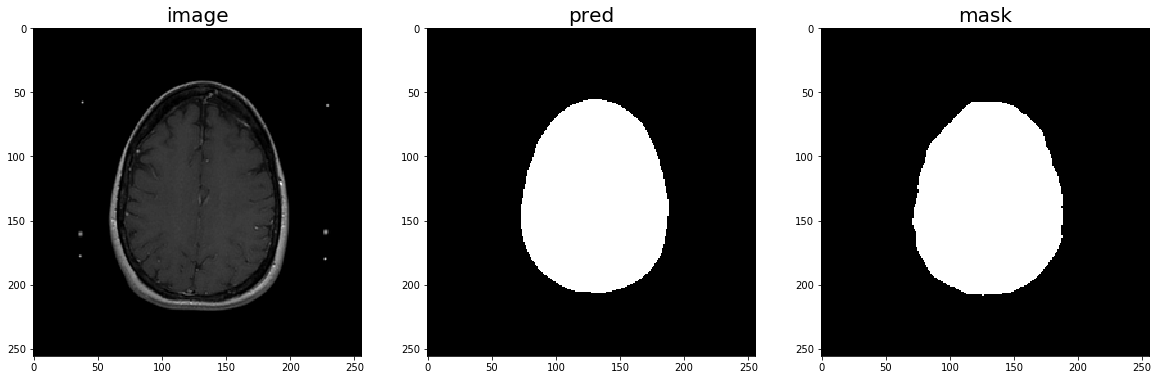

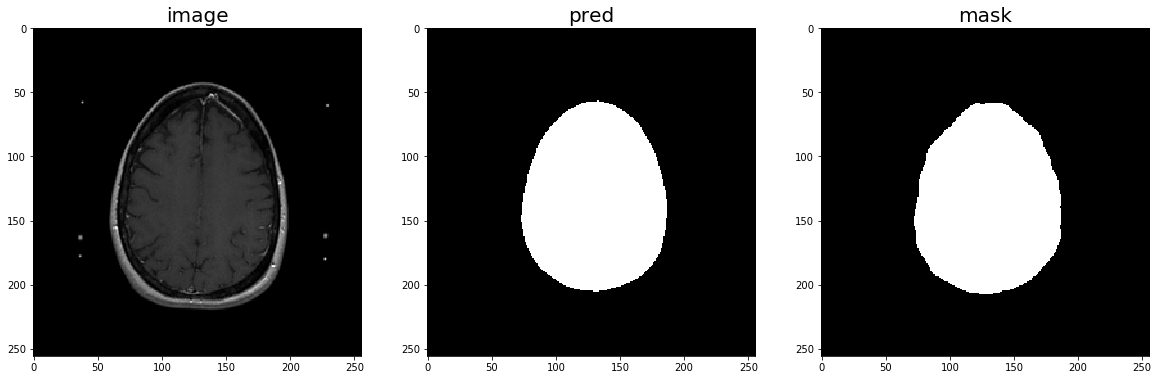

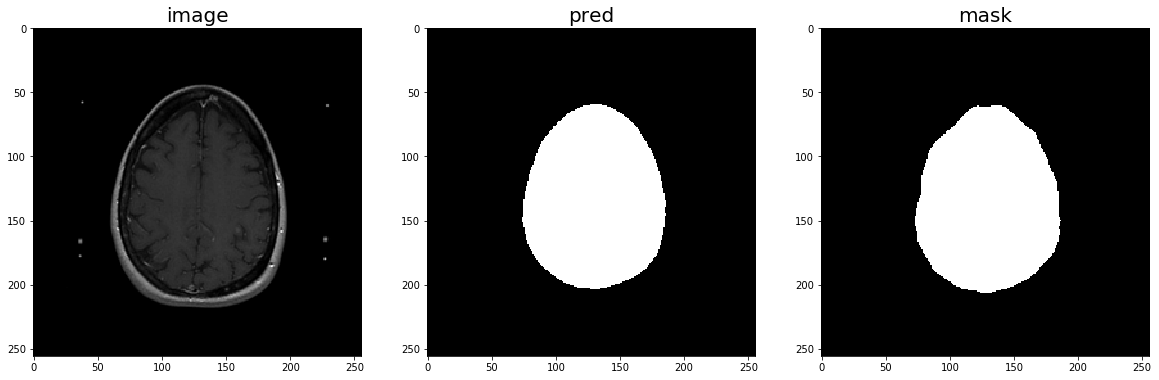

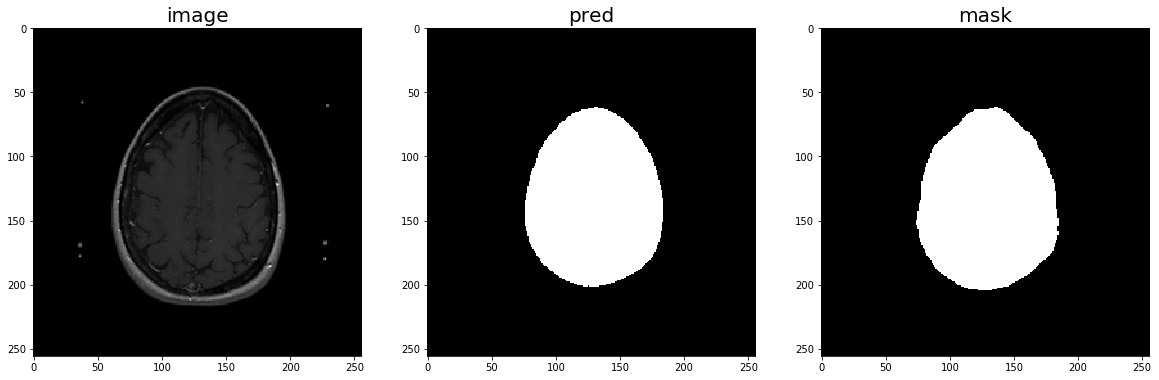

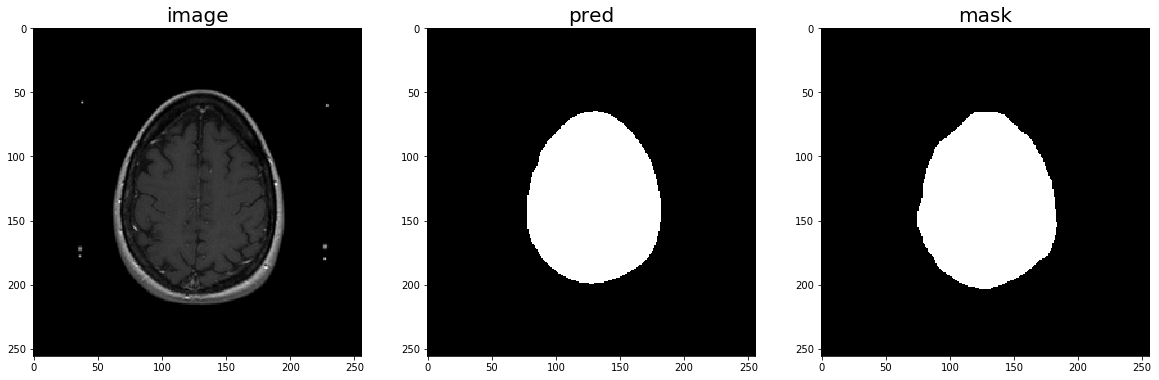

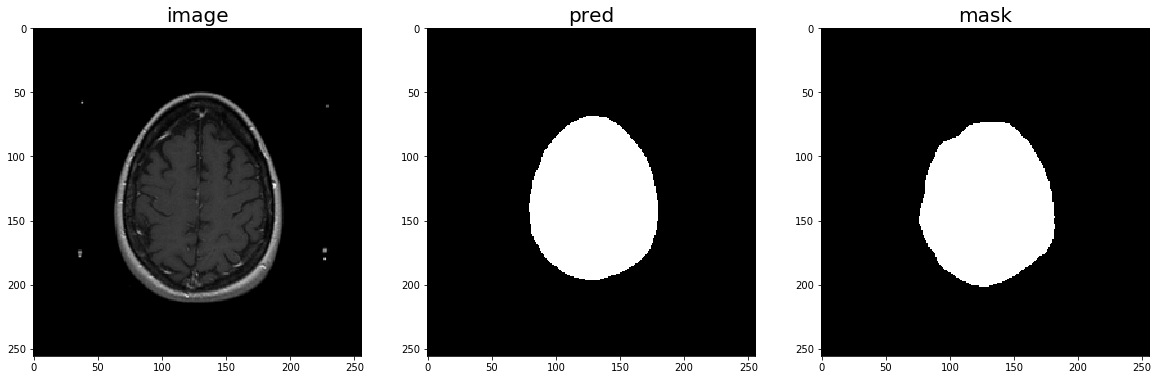

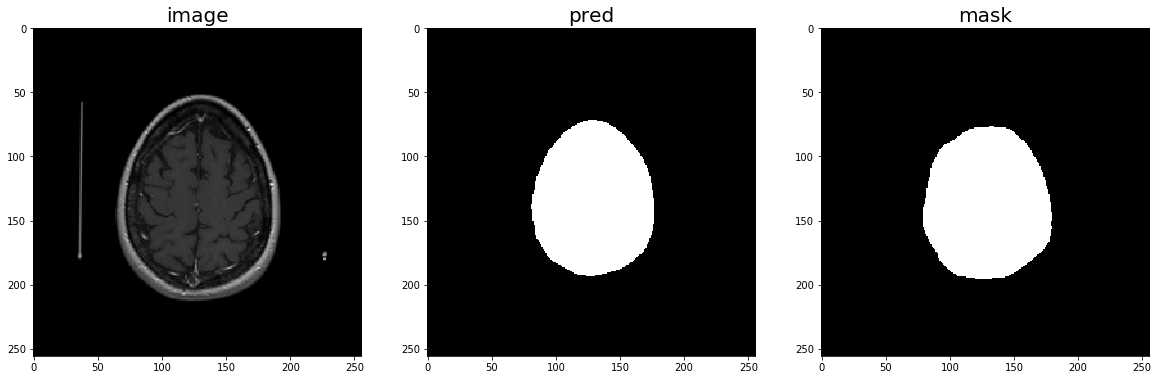

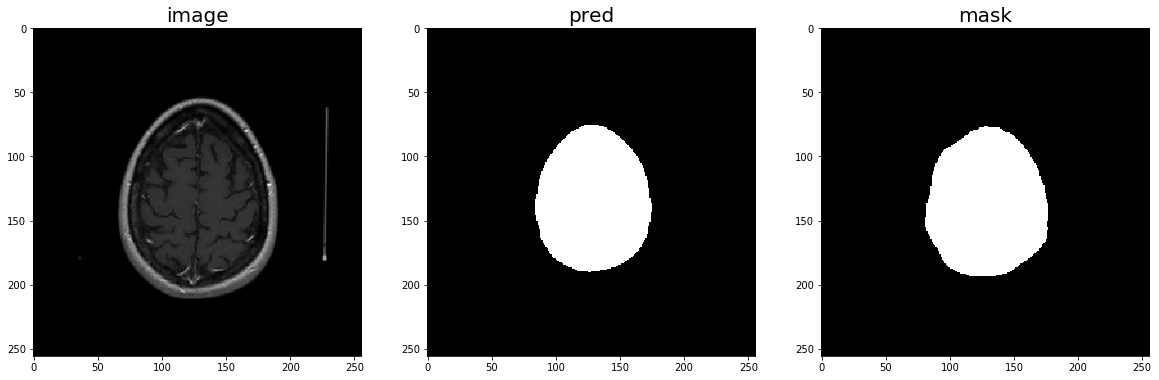

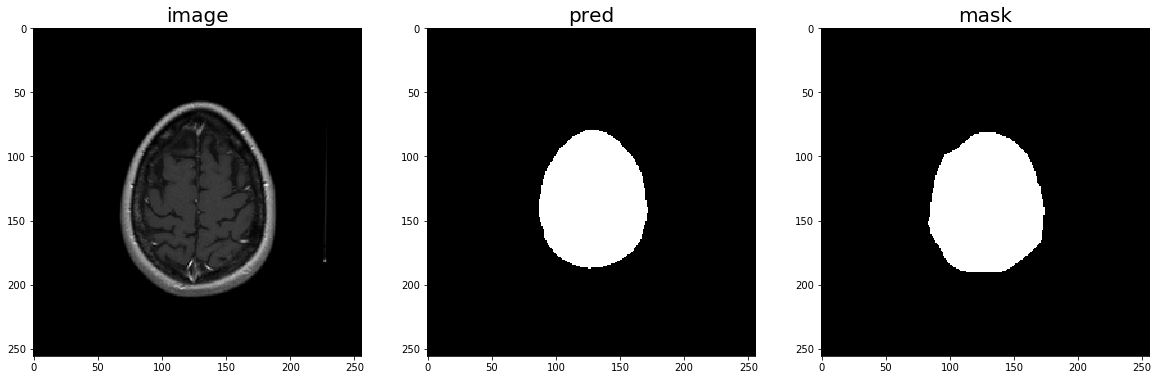

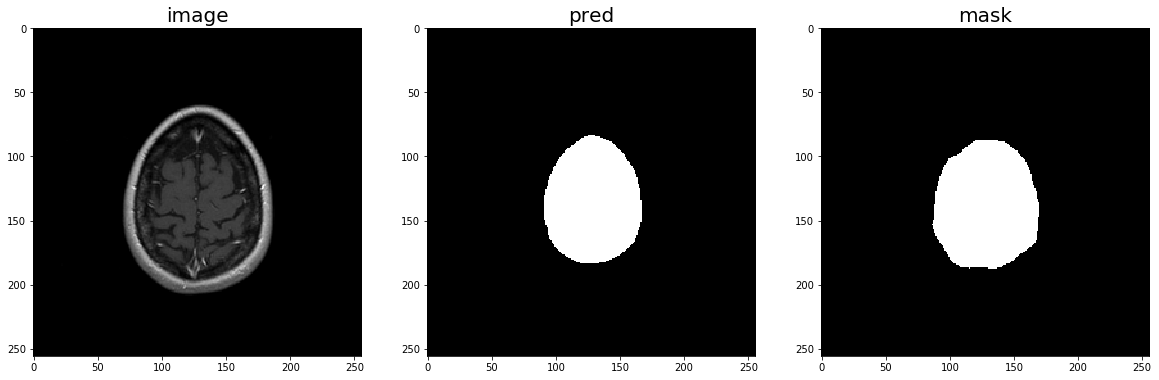

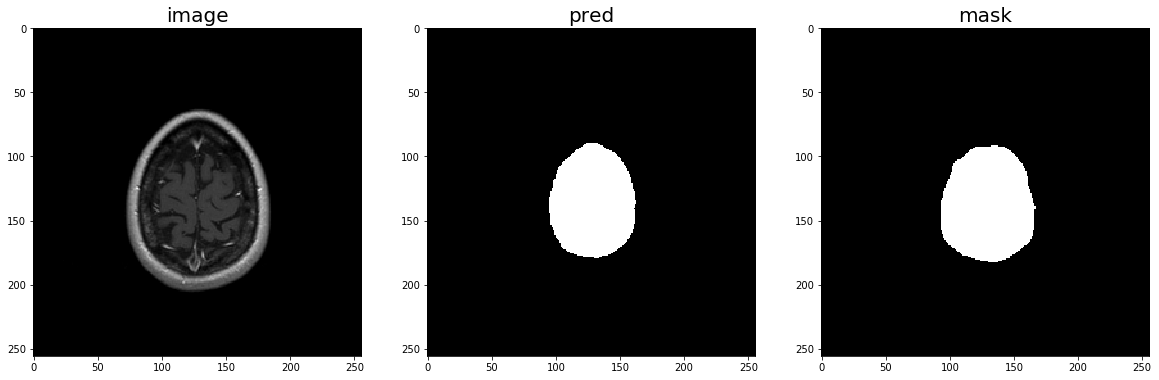

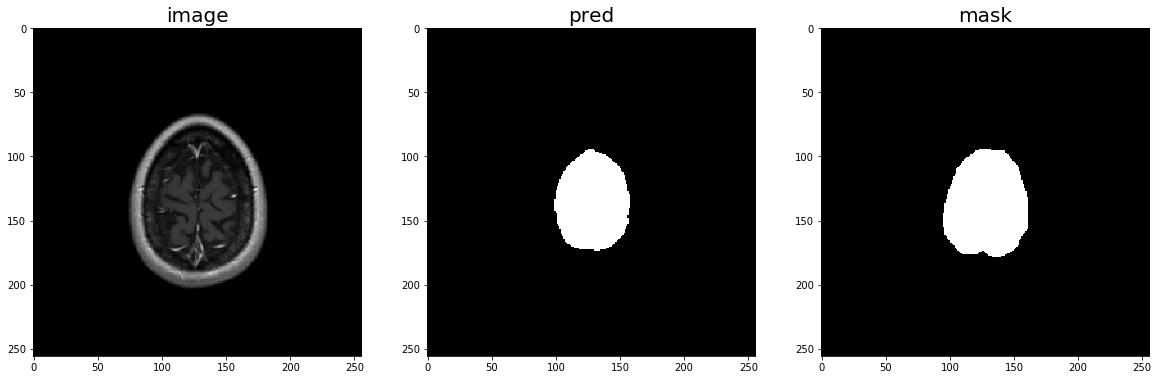

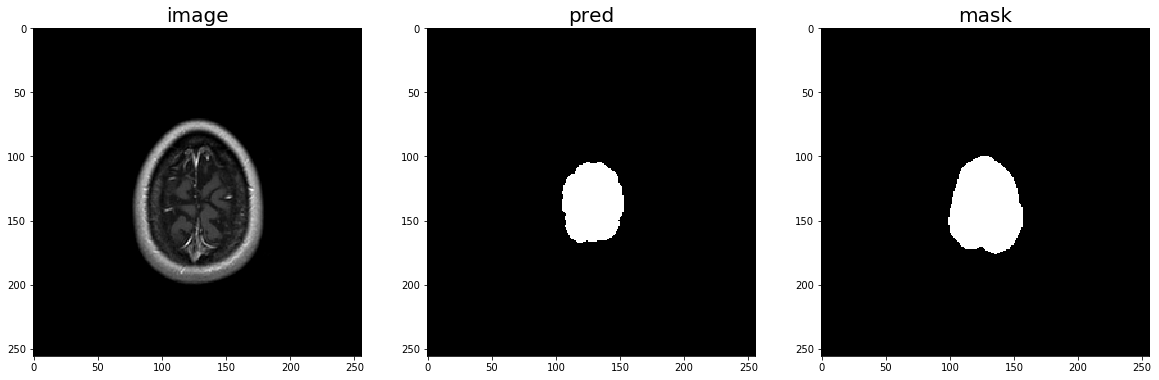

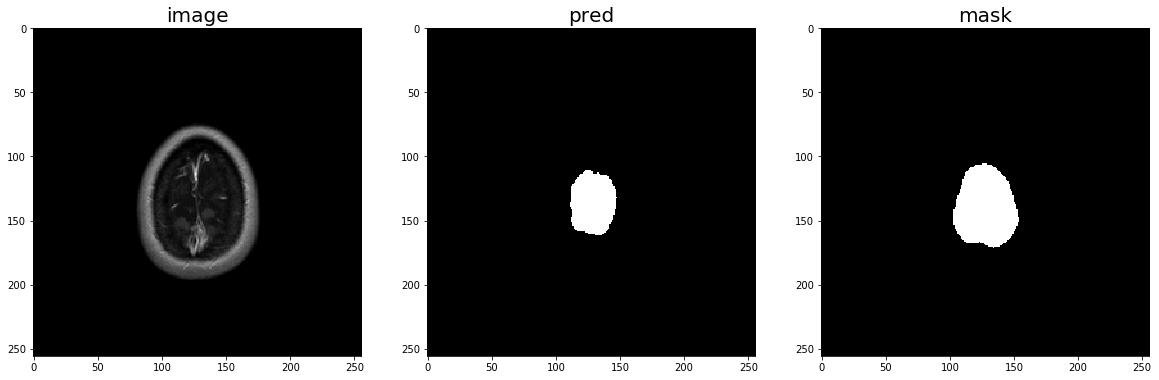

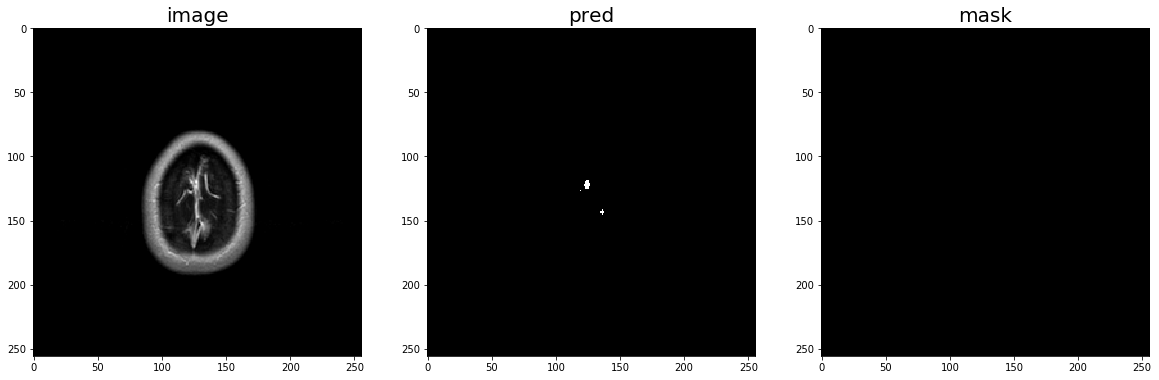

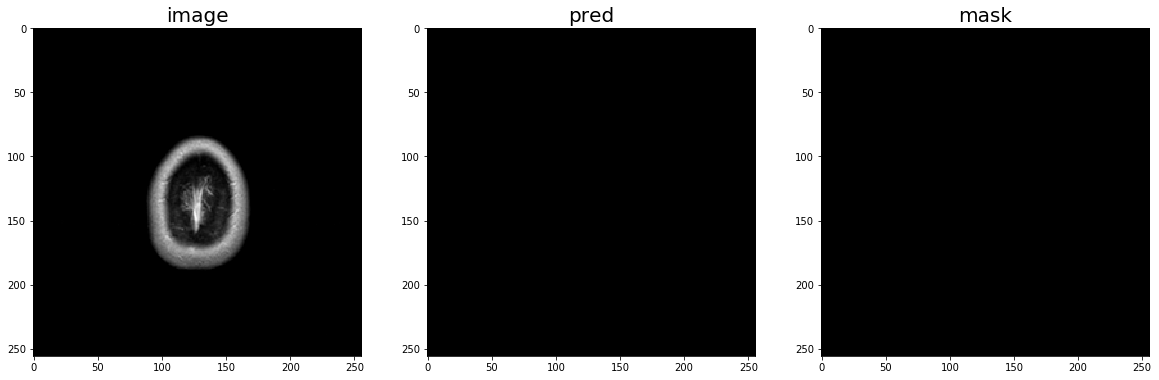

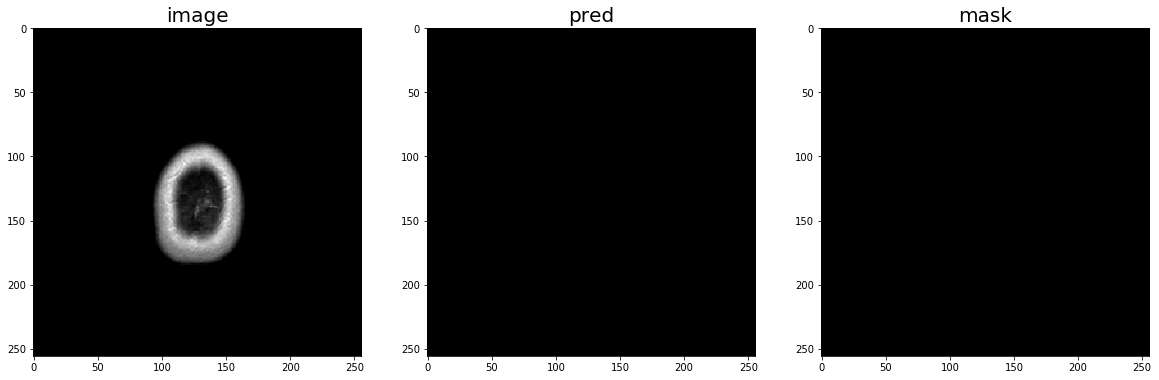

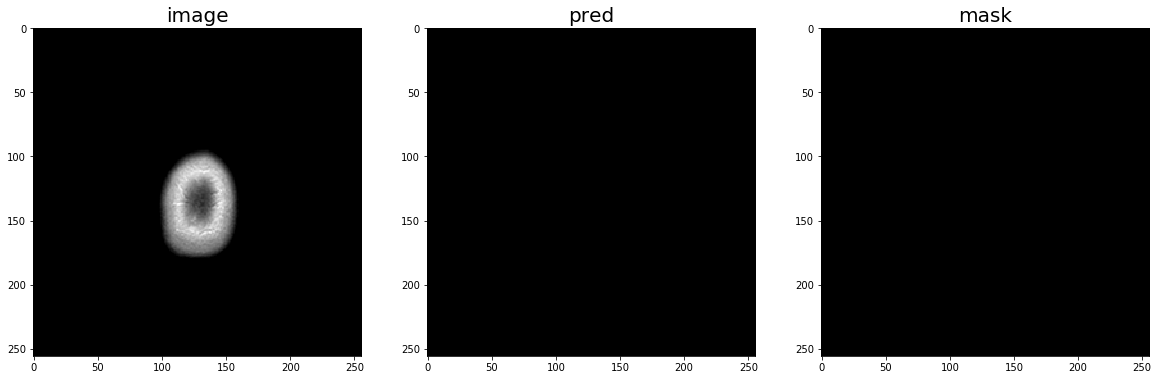

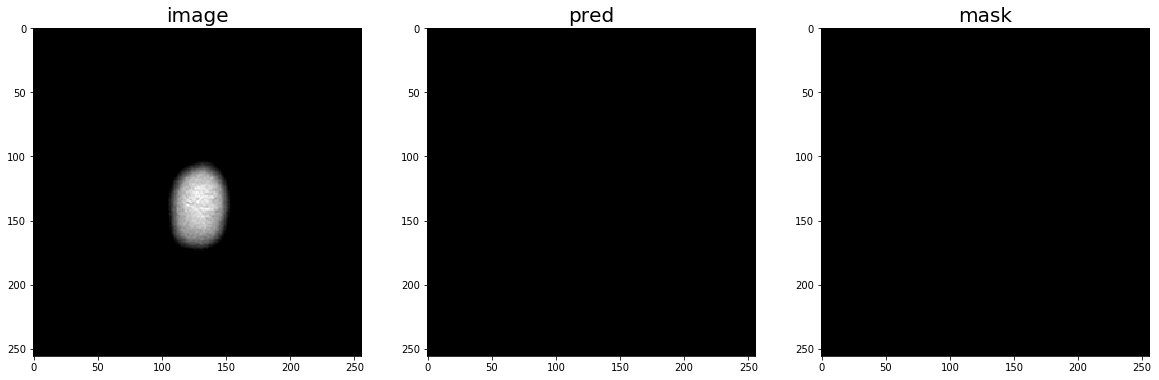

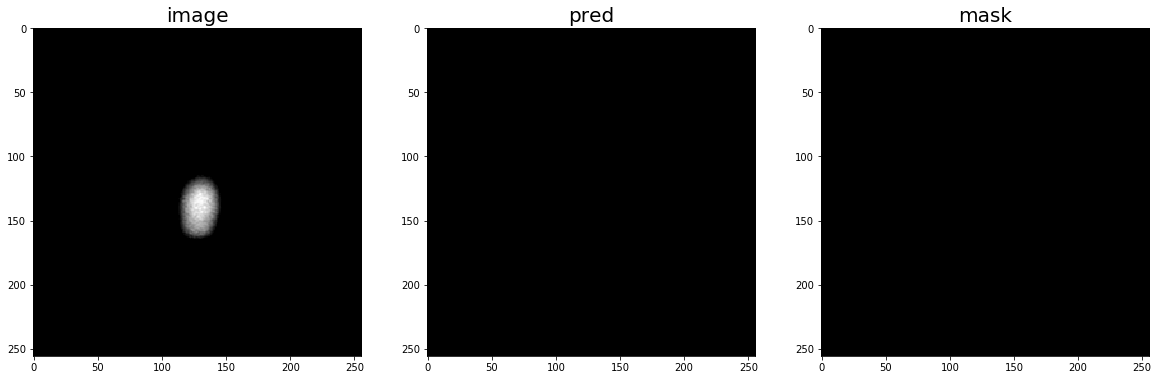

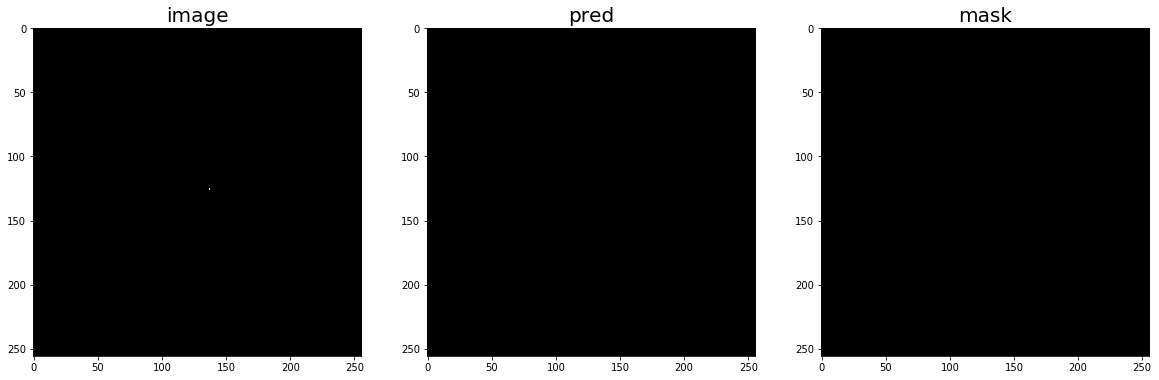

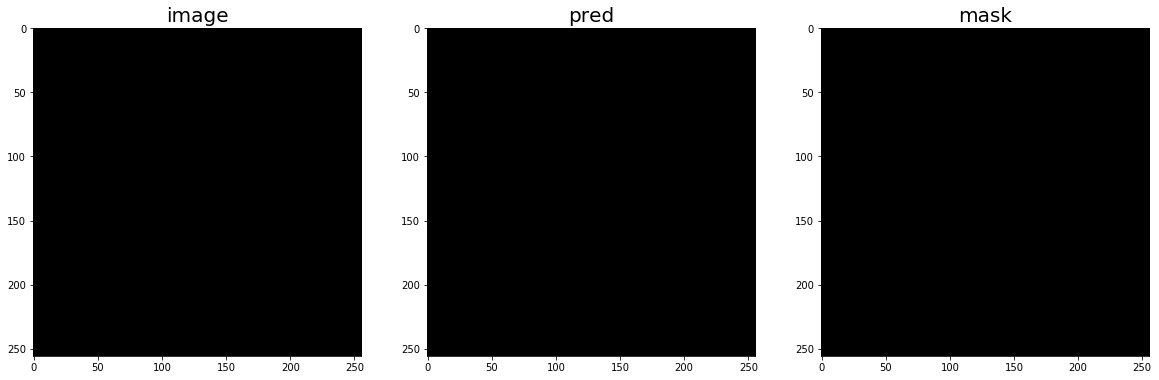

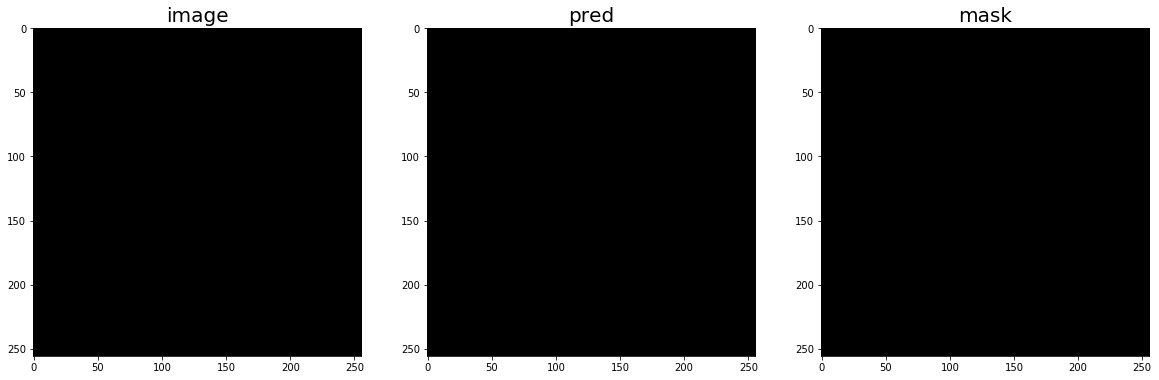

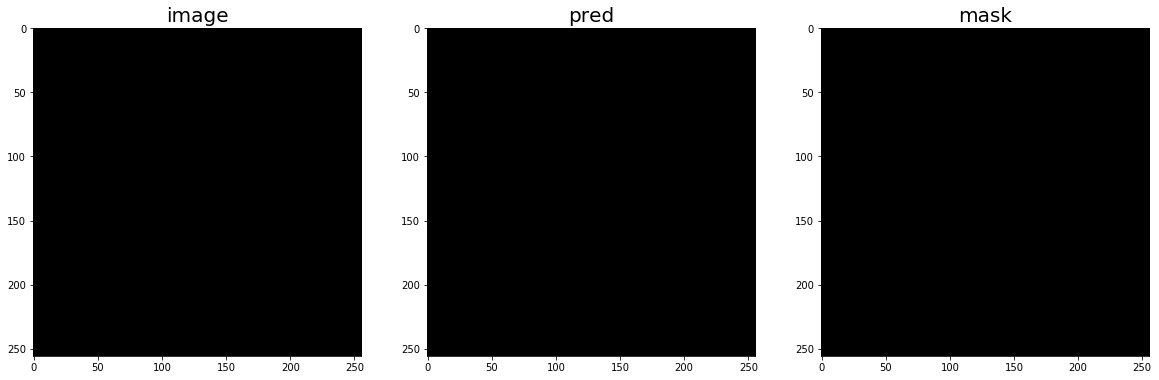

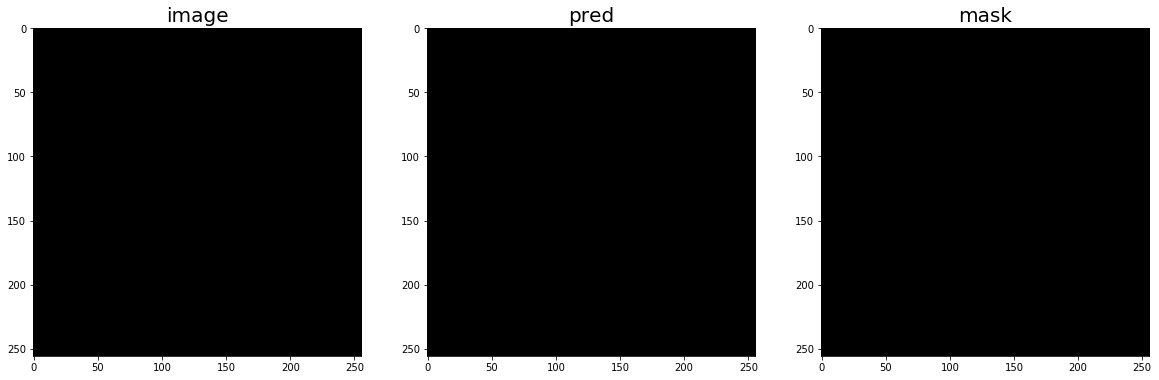

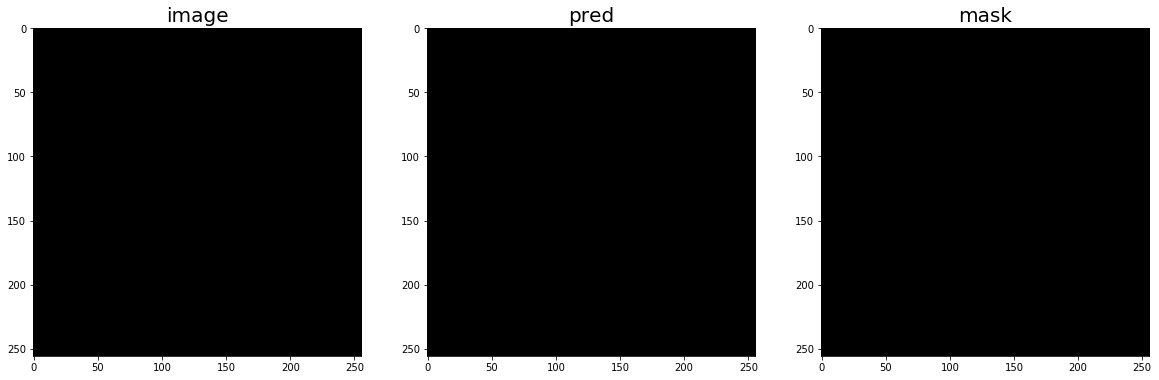

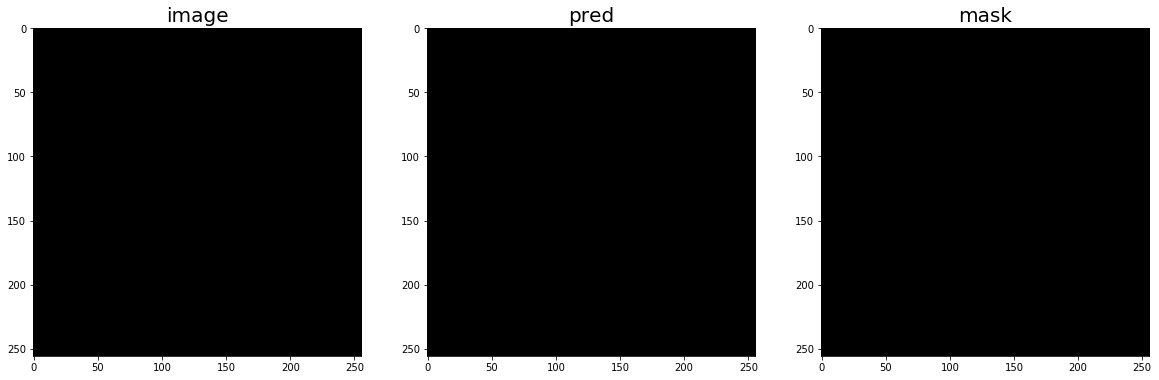

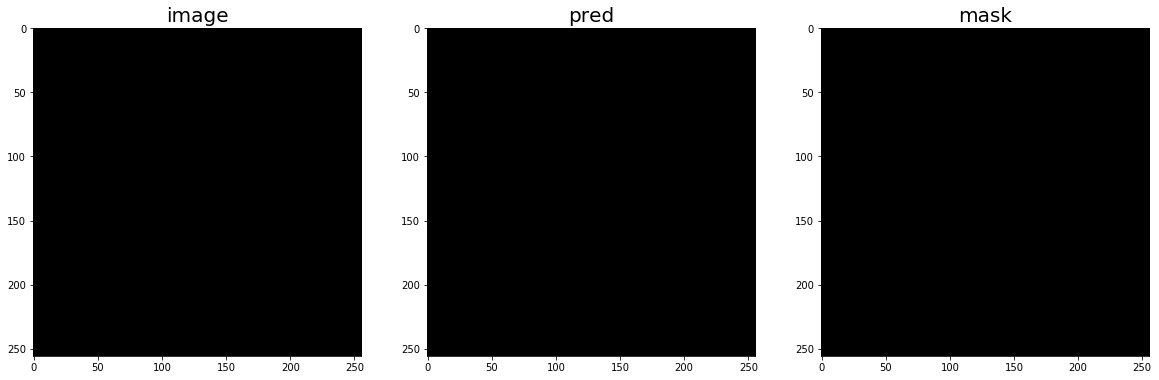

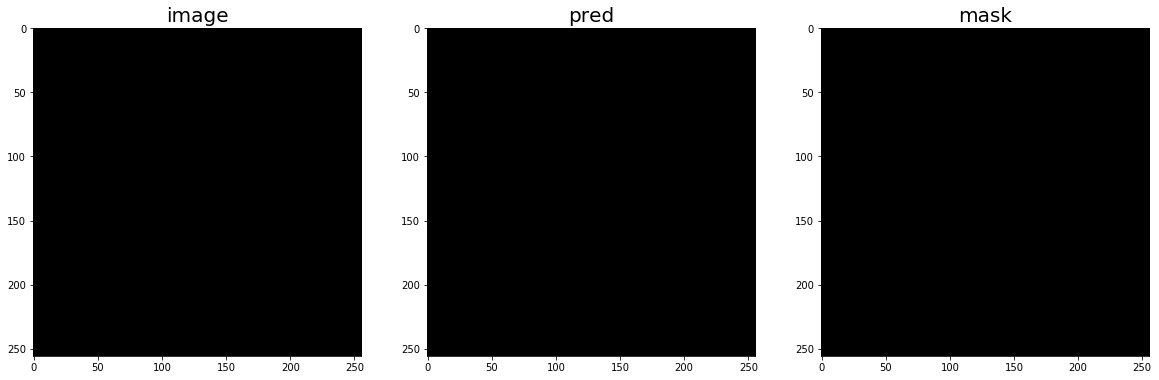

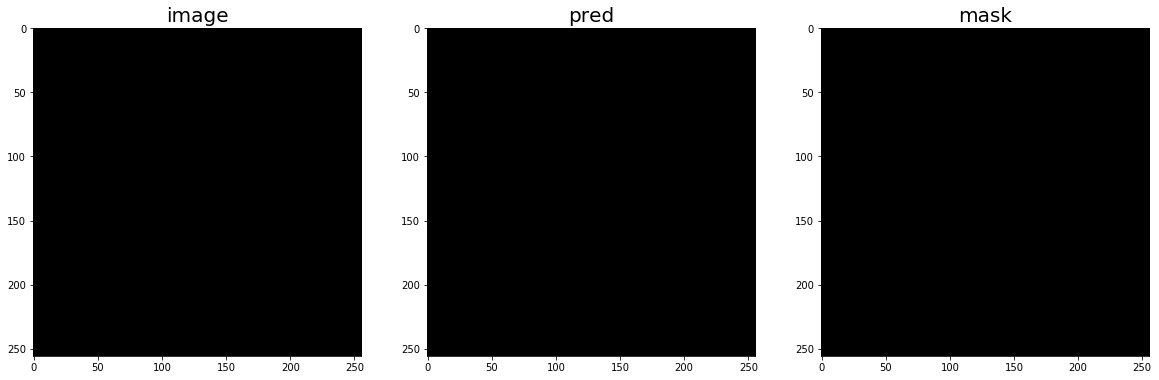

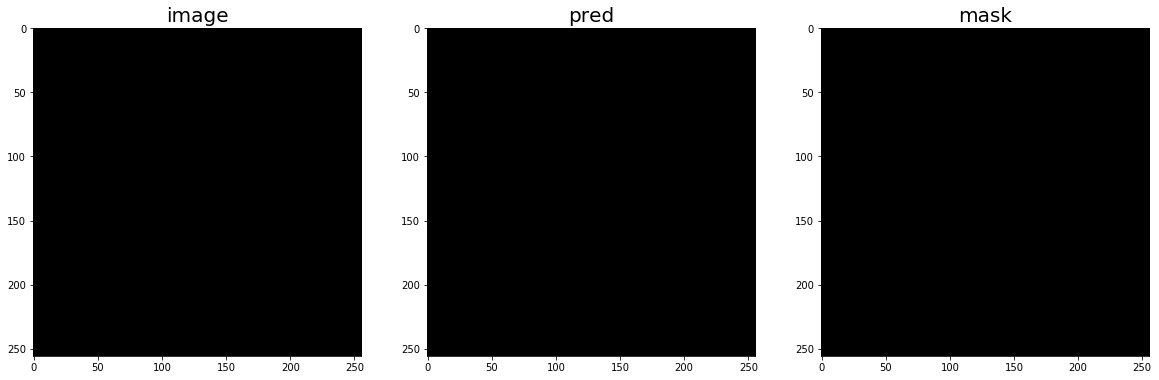

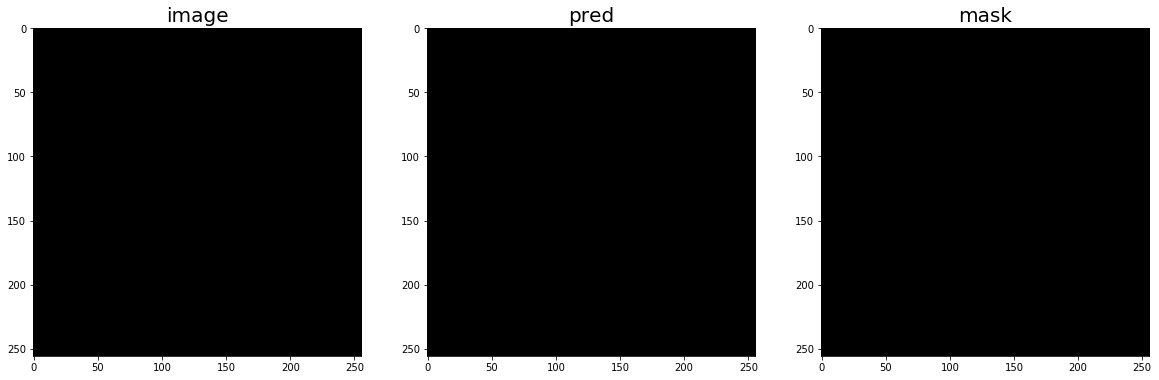

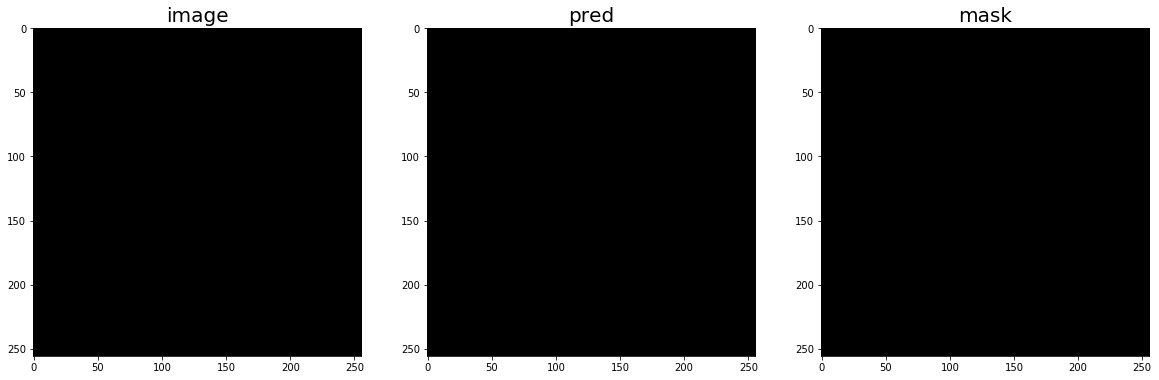

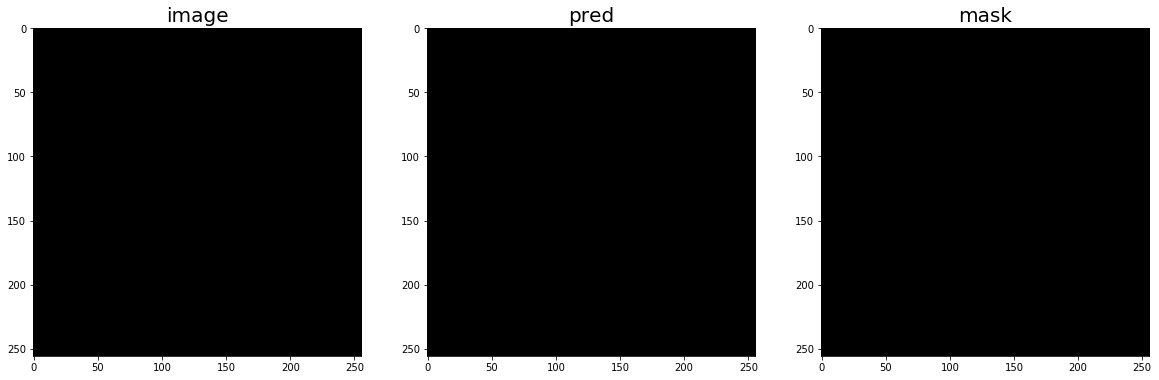

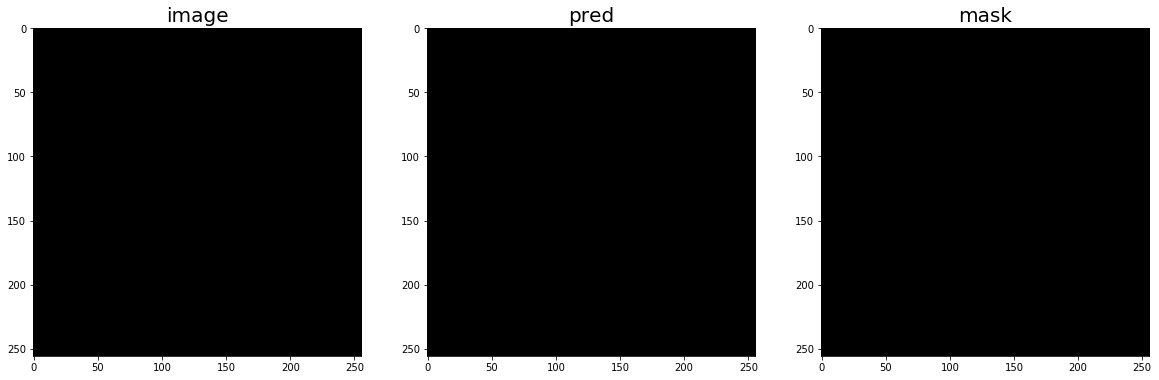

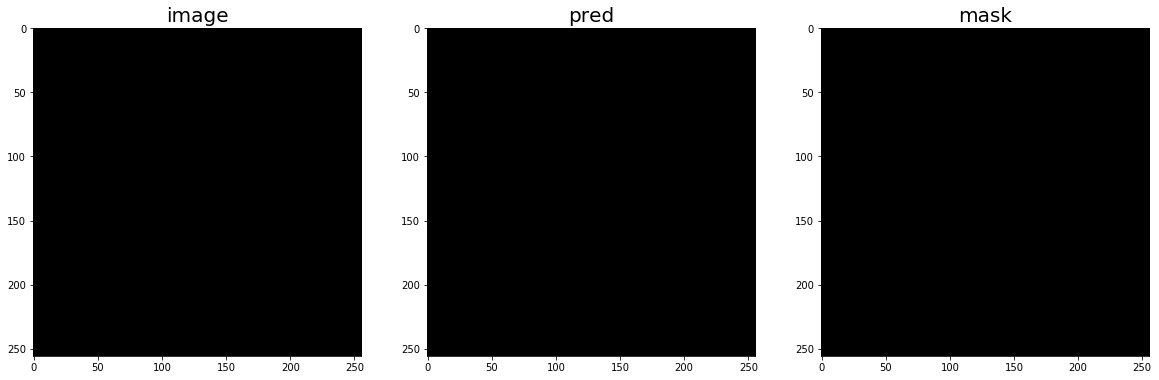

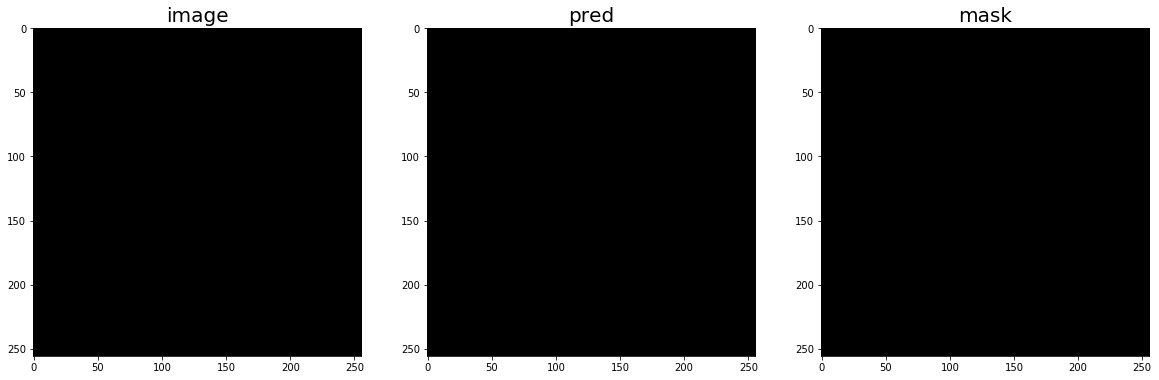

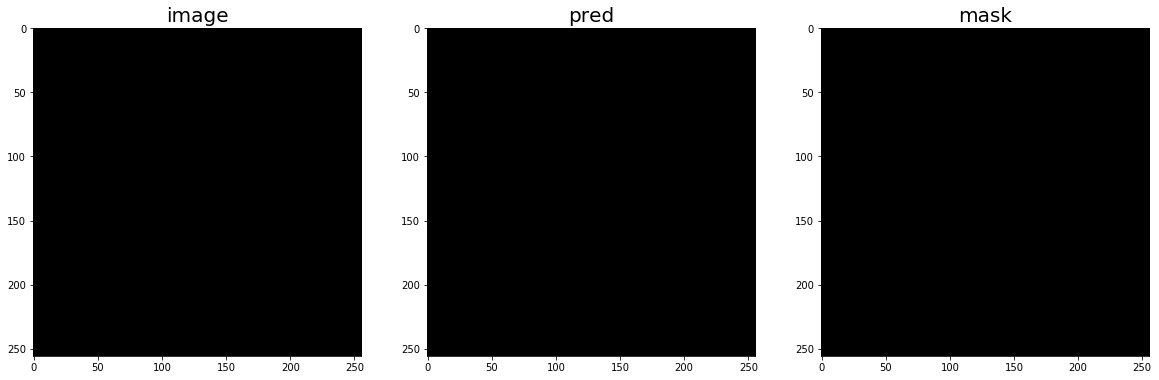

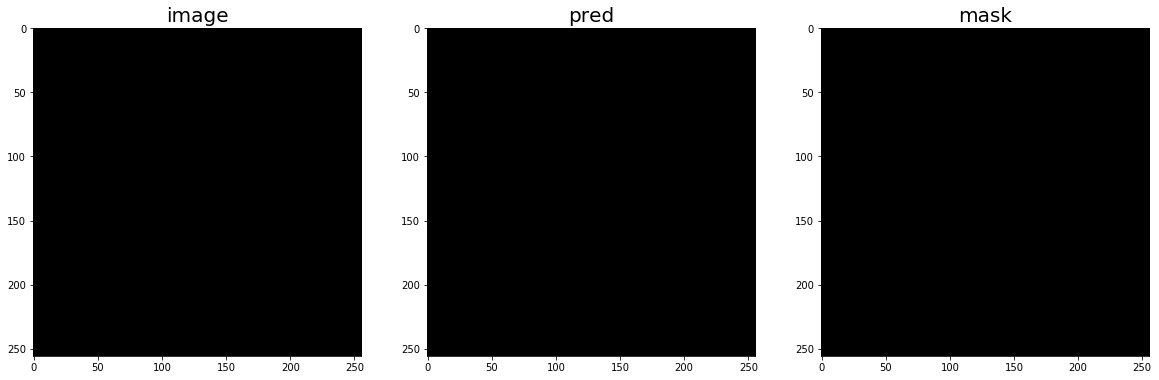

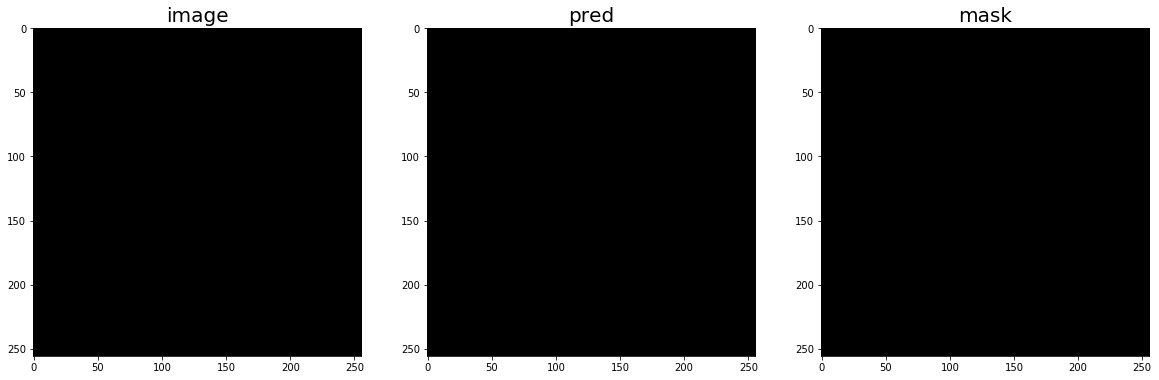

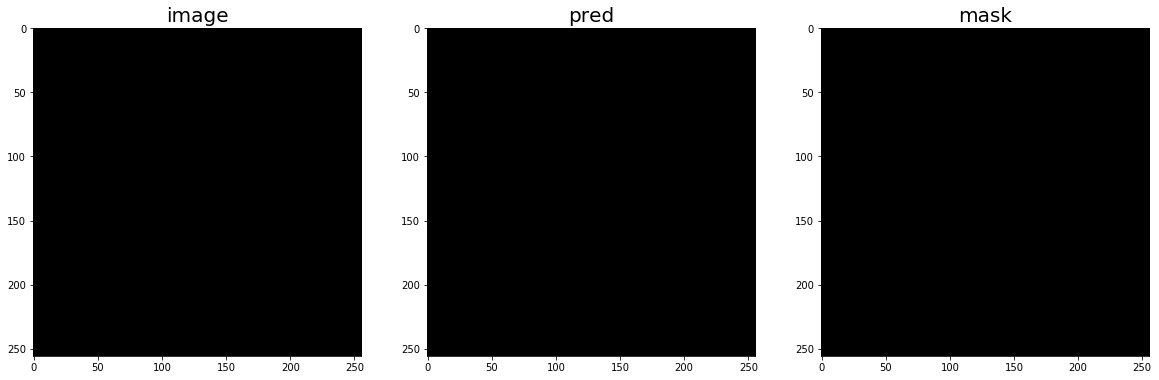

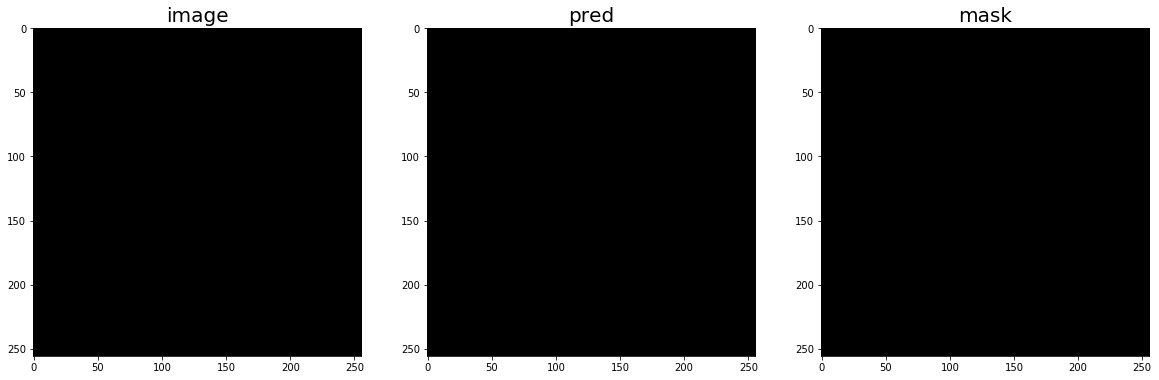

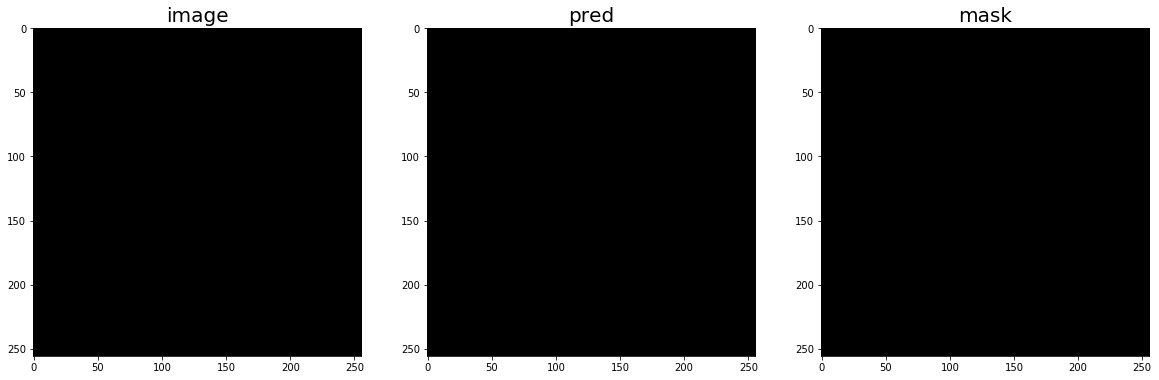

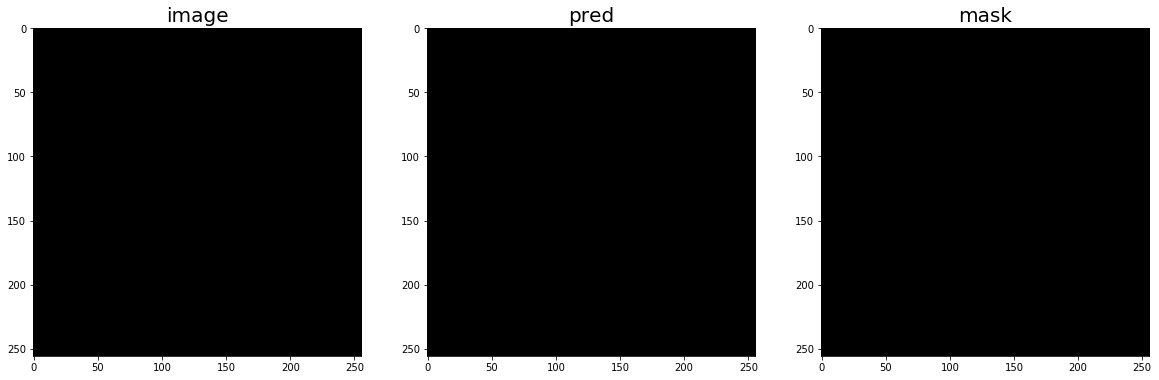

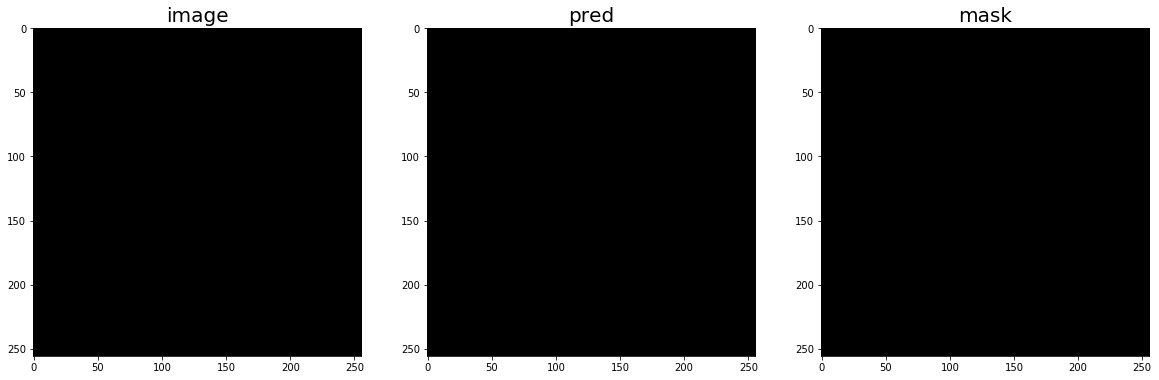

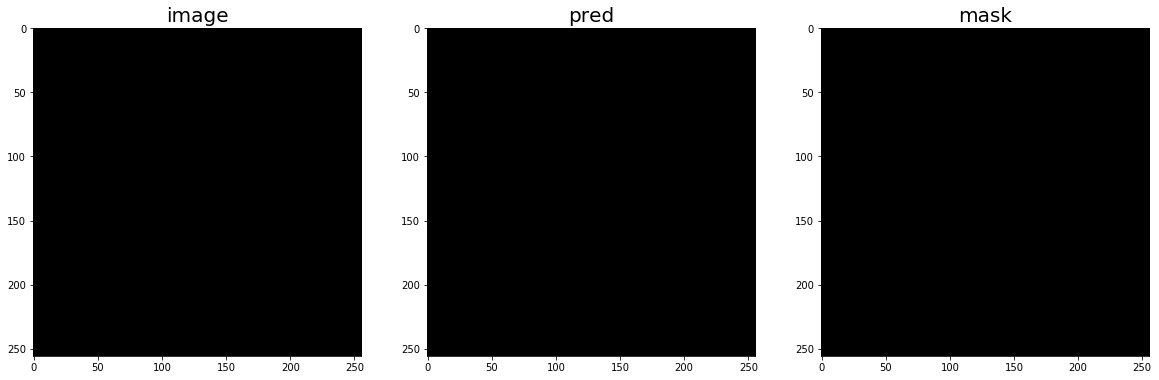

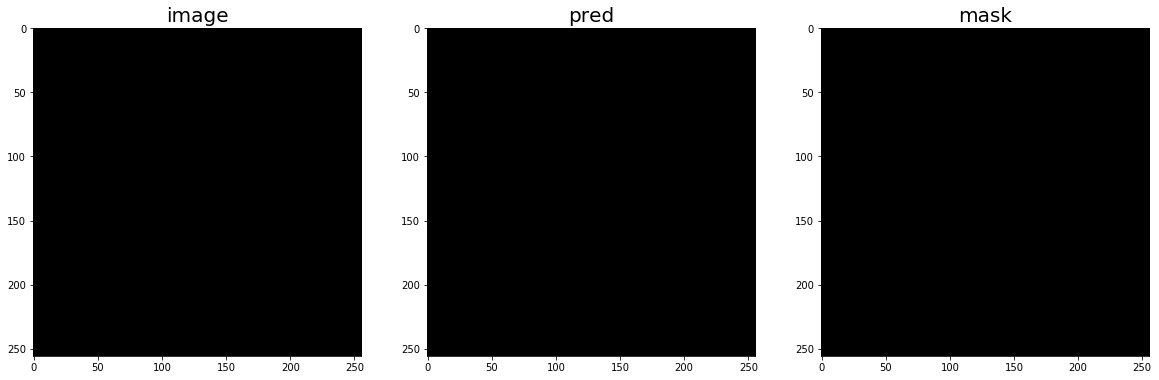

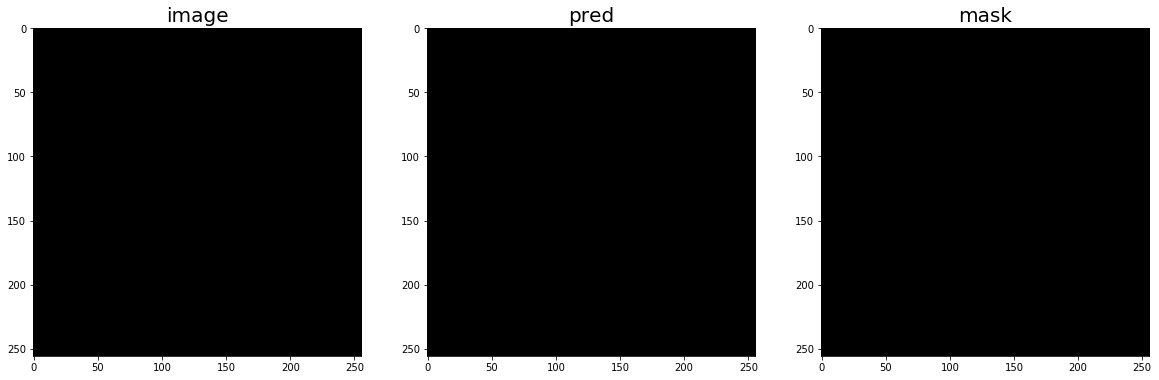

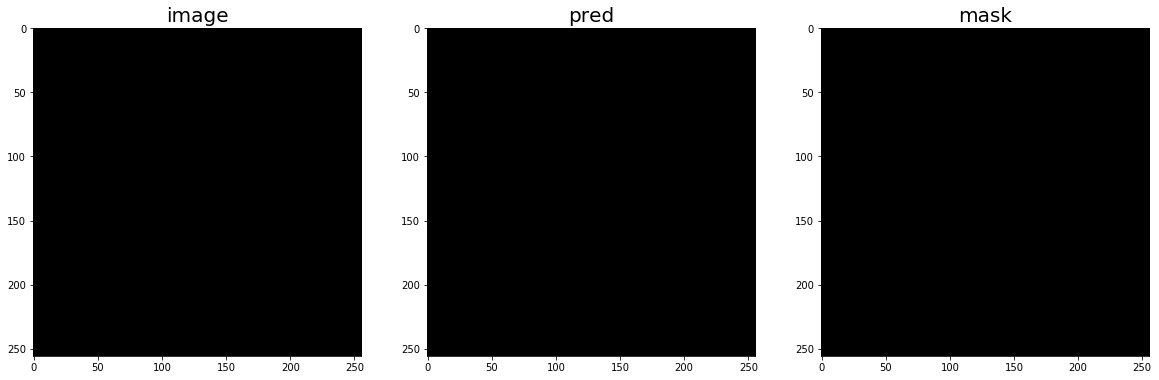

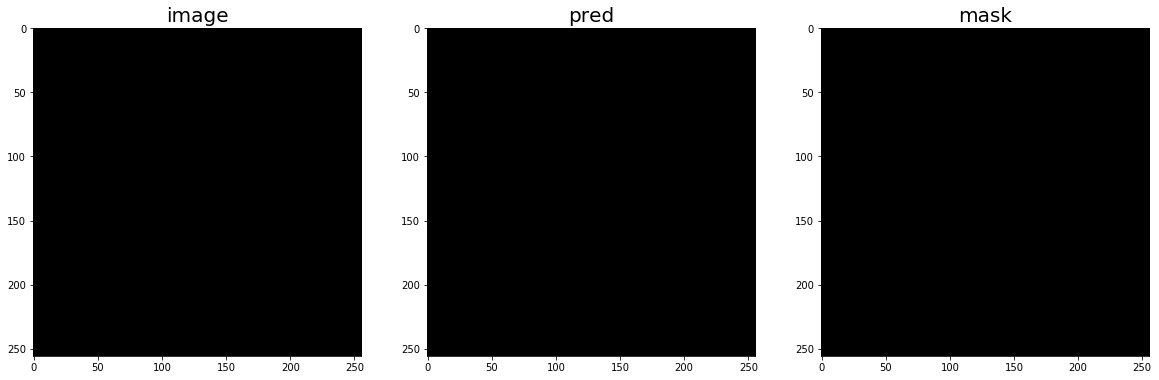

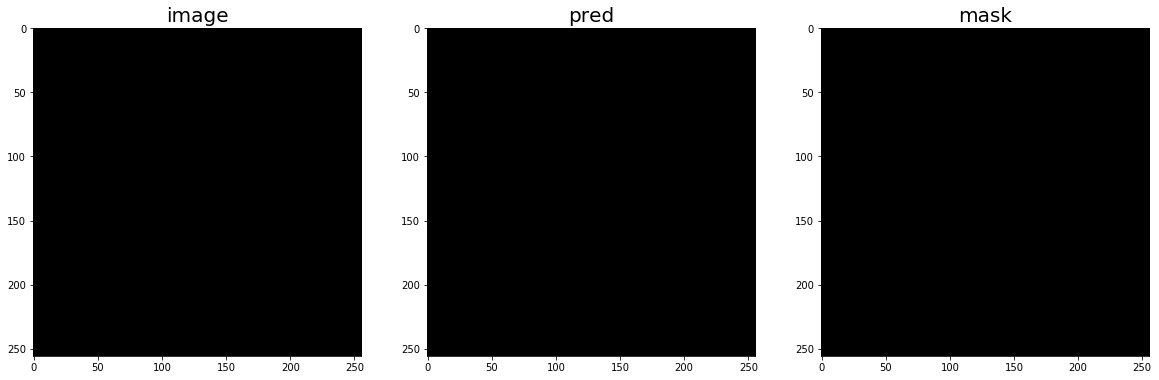

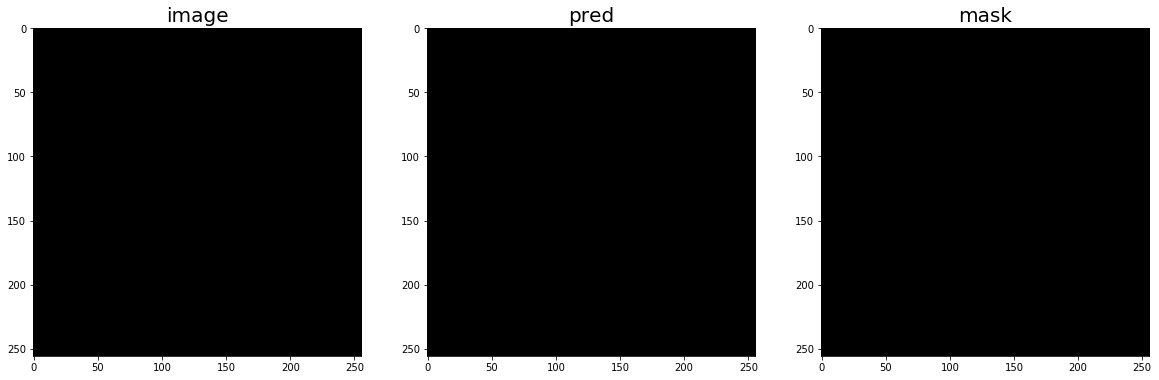

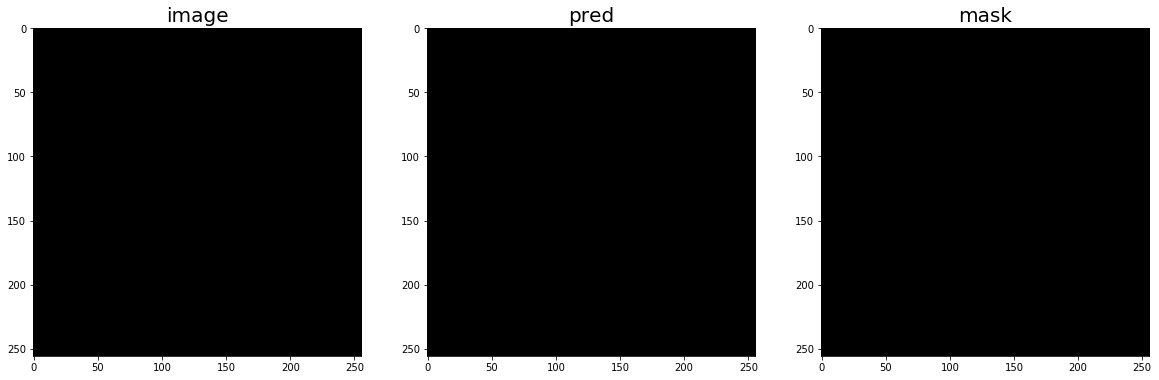

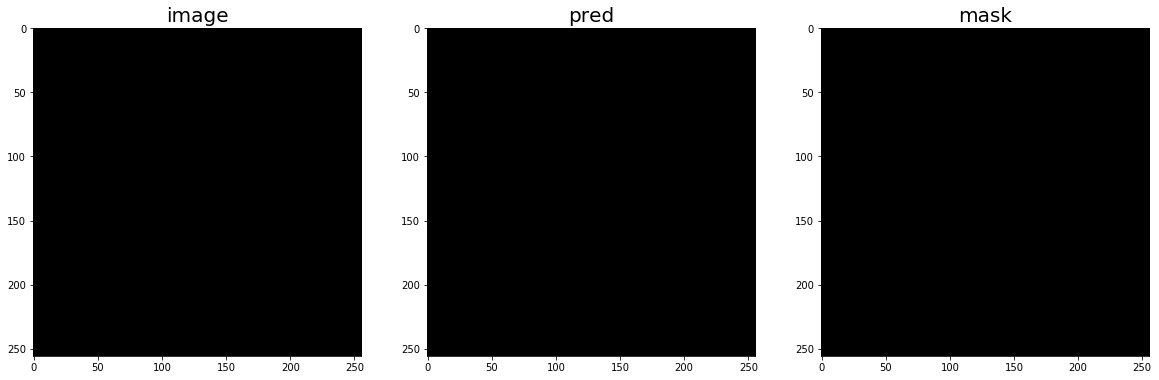

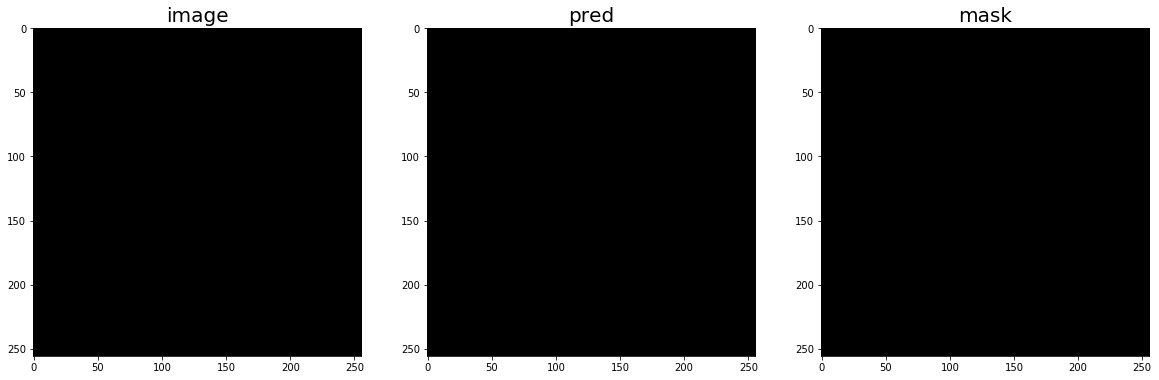

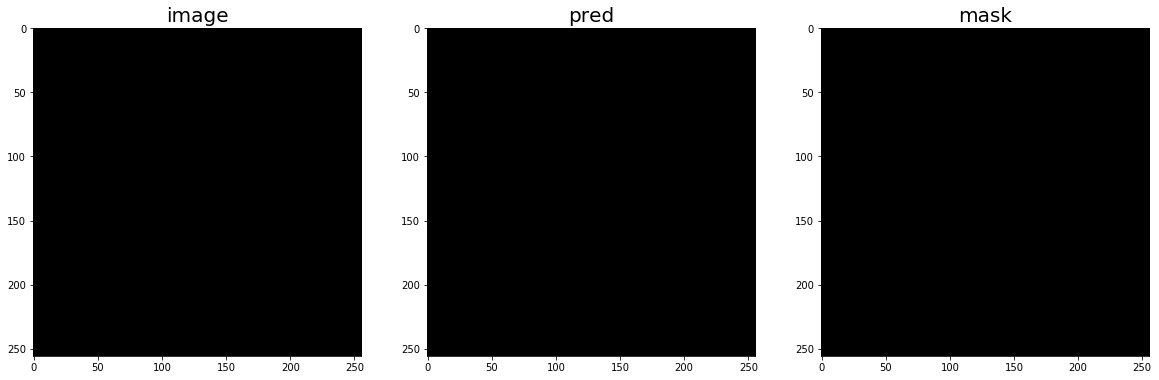

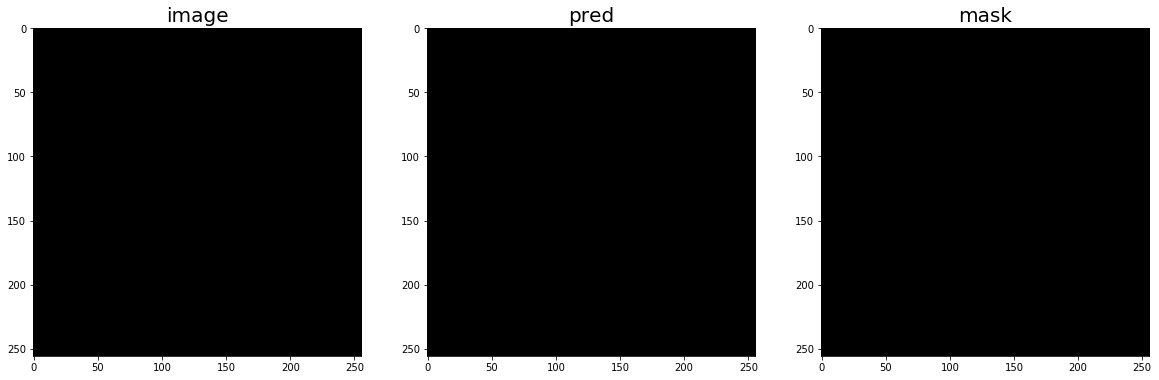

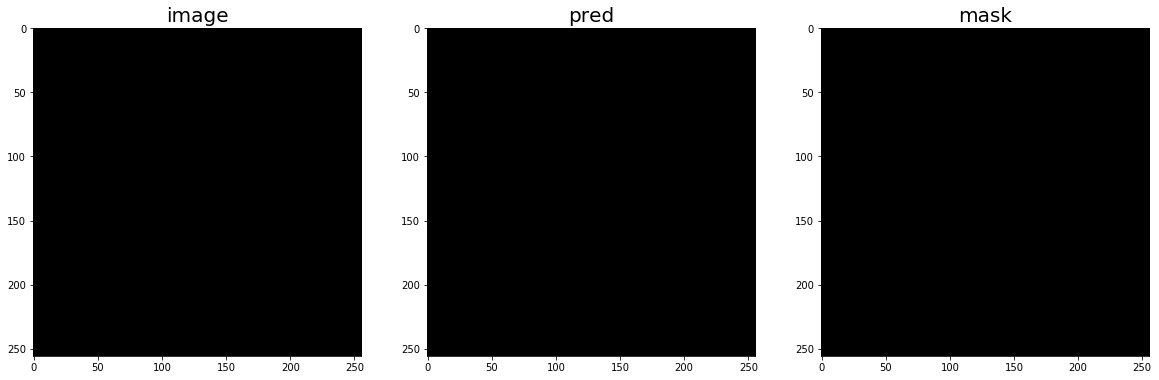

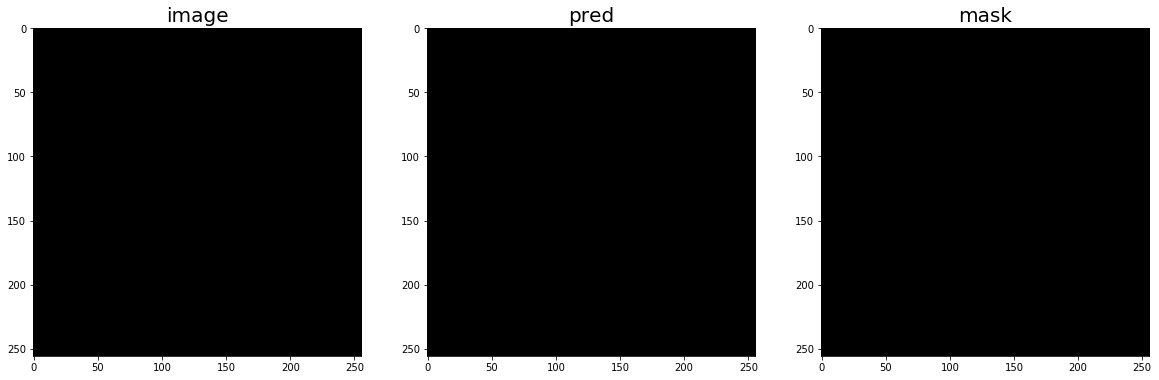

In [25]:
IMG_NUM = 5
image = images[IMG_NUM]
pred = preds[IMG_NUM]
mask = masks[IMG_NUM]
for i in range(image.shape[0]):
    plot_predictions(image[i], pred[i], mask[i])